# Predicción de demanda de transporte

## Introducción

La predicción de demanda de transporte es un área clave en la planificación y gestión de sistemas de transporte modernos, con aplicaciones en una amplia variedad de sectores, desde el transporte público y privado hasta la logística y el transporte de mercancías. Predecir la demanda de transporte con precisión es crucial para optimizar los recursos disponibles, mejorar la eficiencia operativa y reducir costos, todo mientras se mejora la experiencia del usuario.

En un contexto de crecimiento urbano y aumento de la población mundial, las ciudades enfrentan retos significativos en términos de congestión y sostenibilidad del transporte. La capacidad para anticipar con precisión las fluctuaciones en la demanda en función de diversos factores como el tiempo, el día de la semana, el tipo de vehículo, permite a las autoridades y empresas de transporte tomar decisiones informadas. Esto no solo mejora la asignación de recursos, sino que también facilita la creación de políticas públicas más efectivas y sostenibles.

Este trabajo se enfoca en el uso de técnicas avanzadas de análisis de datos, incluyendo modelos de machine learning y modelos estadísticos, para prever la demanda de transporte en un entorno urbano. El objetivo es entender los patrones de uso de diferentes modos de transporte y desarrollar un modelo predictivo capaz de anticipar las necesidades de los usuarios bajo diversas condiciones. A través de este enfoque, se pretende proporcionar herramientas útiles para la toma de decisiones estratégicas en la planificación de rutas, horarios y recursos, lo que, a su vez, contribuye a la mejora del servicio y la reducción de la congestión en las ciudades.

## Creación del Dataset

In [1]:
# Ahora importamos las librerias necesarias
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from datetime import timedelta, datetime

from prophet import Prophet


Para este caso, vamos a simular un dataset que representa los registros de viajes de una empresa de transporte. Este conjunto de datos reflejará información relevante de los viajes realizados entre cinco puntos de destino: Lugar_A, Lugar_B, Lugar_C, Lugar_D, Lugar_E. La simulación incluirá las siguientes variables:

**Id_viaje**: Una identificación única para cada viaje realizado, que será representada por un número consecutivo (por ejemplo, 1, 2, 3, …) que facilita la gestión y trazabilidad de los registros.

**fecha_viaje**: La fecha exacta en la que se realizó el viaje. Este valor se generará aleatoriamente, eligiendo un día dentro de un periodo de un año, comenzando desde el 1 de enero de 2024.

**hora_viaje**: El tiempo específico en el que el viaje comienza. Este valor se generará utilizando una función aleatoria que asigna horas y minutos dentro de un rango de 24 horas.

**origen y destino**: Estos campos corresponderán a los lugares de origen y destino del viaje, los cuales se seleccionarán aleatoriamente entre los cinco lugares disponibles. Es importante notar que un viaje no puede tener como origen y destino el mismo lugar, lo que será validado en la generación de los datos para fines prácticos.

**tipo_carro**: Se refiere al tipo de vehículo utilizado para el viaje. Los valores posibles serán 'bus', 'minibus' o 'van', y se asignarán de forma aleatoria según las proporciones de uso en el transporte de cada tipo.

**cupo_max**: El número máximo de pasajeros que el vehículo puede transportar, lo cual se ajustará según el tipo de vehículo. Los posibles valores serán 14, 30 y 50, y se asignarán aleatoriamente a cada viaje en función del tipo de vehículo seleccionado.

**metodo_pago**: El método de pago utilizado para el viaje, el cual podrá ser 'efectivo', 'pago_movil' o 'tarjeta'. Este dato se generará aleatoriamente.

**asientos_vendidos**: Este campo representará la cantidad de asientos vendidos para cada viaje, calculado de acuerdo con una serie de factores como la capacidad máxima del vehículo, el horario del día, el tipo de pago, y otros patrones probabilísticos asociados a la demanda.

Para simular estos datos, utilizaremos una combinación de funciones aleatorias y distribuciones estadísticas que reflejan patrones comunes en la demanda de transporte, tales como la mayor demanda de asientos en ciertos horarios o la preferencia por ciertos métodos de pago. El tamaño de nuestro dataset será de 10,000 registros para asegurar que sea representativo de diferentes patrones de demanda y variabilidad.


In [2]:
# fijamos la semilla
np.random.seed(123)

# Algunos parametros para crear el dataset
n_samples = 10000  # Numero de viajes
ciudades = ['Lugar_A', 'Lugar_B', 'Lugar_C', 'Lugar_D', 'Lugar_E']
car_types = ['bus', 'minibus', 'van']
metodo_pago = ['efectivo', 'transferencia', 'tarjeta de credito']
start_date = datetime(2024, 1, 1)

# generamos los datos
ride_ids = np.arange(1, n_samples + 1)
travel_dates = [start_date + timedelta(days=np.random.randint(0, 365)) for _ in range(n_samples)]
travel_times = [datetime(2024, 1, 1, np.random.randint(0, 24), np.random.randint(0, 60)).time() for _ in range(n_samples)]
travel_from = np.random.choice(ciudades, n_samples)
travel_to = np.random.choice(ciudades, n_samples)
car_type = np.random.choice(car_types, n_samples)
max_capacity = np.random.choice([14, 30, 50], n_samples)
payment_method = np.random.choice(metodo_pago, n_samples)

# Calcular el número de asiento basándose en cierta lógica por ejemplo el tipo de vehiculo, la capacidad, la hora del día y el método de pago afectan el número de asiento
# por ejemplo el tipo de vehiculo, la capacidad, la hora del día y el método de pago afectan el número de asiento
seat_number = (np.random.poisson(lam=10, size=n_samples)
               + (max_capacity / 2).astype(int)
               + np.random.randint(0, 5, n_samples)
               - (np.array([t.hour for t in travel_times]) // 3)
               + (payment_method == 'transferencia').astype(int) * 5
              ).clip(1, max_capacity)  # Asegúrese de que el número de asiento esté entre 1 y la capacidad máxima

# Creamos el DataFrame
data = pd.DataFrame({
    'Id_viaje': ride_ids,
    'fecha_viaje': travel_dates,
    'hora_viaje': travel_times,
    'origen': travel_from,
    'destino': travel_to,
    'tipo_carro': car_type,
    'cupo_max': max_capacity,
    'metodo_pago': payment_method,
    'asientos_vendidos': seat_number
})

#data.to_csv("viajes.csv", index=False)
data.head()

Id_viaje fecha_viaje hora_viaje   origen  destino tipo_carro  cupo_max  \
0         1  2024-11-18   11:08:00  Lugar_D  Lugar_A    minibus        50   
1         2  2024-04-08   19:44:00  Lugar_C  Lugar_B    minibus        14   
2         3  2024-08-18   04:13:00  Lugar_A  Lugar_D        van        14   
3         4  2024-01-18   06:10:00  Lugar_C  Lugar_C        bus        50   
4         5  2024-03-24   17:54:00  Lugar_B  Lugar_E    minibus        30   

          metodo_pago  asientos_vendidos  
0            efectivo                 39  
1       transferencia                 14  
2  tarjeta de credito                 14  
3  tarjeta de credito                 32  
4            efectivo                 17

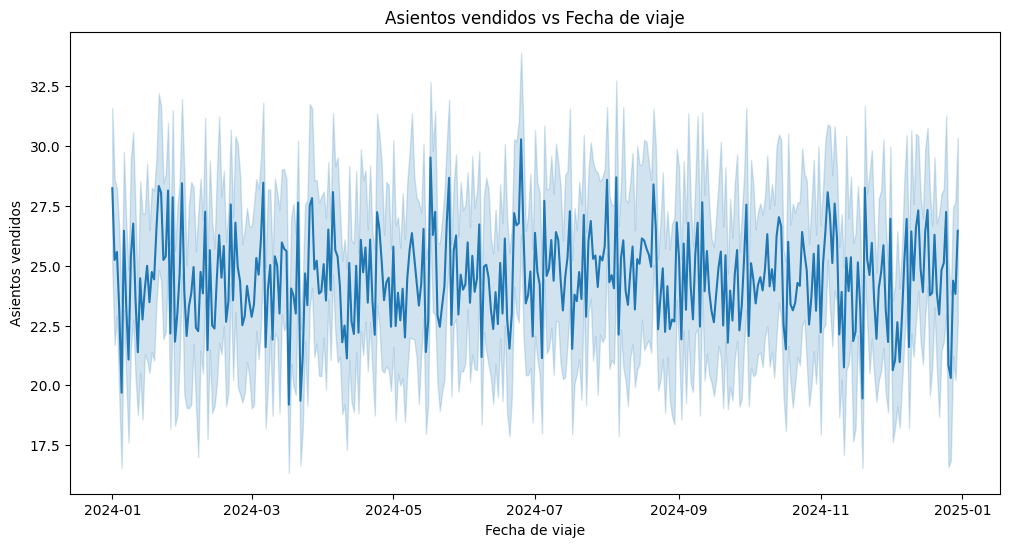

In [3]:
# graficamos lo datos obtenidos fecha de viaje vs asientos vendidos
plt.figure(figsize=(12, 6))
sns.lineplot(data=data, x='fecha_viaje', y='asientos_vendidos')
plt.title('Asientos vendidos vs Fecha de viaje')
plt.xlabel('Fecha de viaje')
plt.ylabel('Asientos vendidos')
plt.show()

## Preprocesamiento de datos

### Ingeniería de caracteristicas
Ahora vamos a convertir la variable **fecha_viaje** y **hora_viaje**  a formato datetime, esto para extraer información importante como el dia de la semana el mes y la hora del viaje poniendo esto en nuevas variables:
- **dia_semana** : Contiene información del dia de la semana en el que se realiza el viaje, los valores son de 0 a 6 (donde 0 es Lunes y 6 es domingo)
- **mes** : Contiene información del mes en el que se raliza el viaje, los valores son de 1 a 12 (donde 1 es Enero y 12 Diciembre)
- **hora** : Contiene información de la hora en que se realiza el viaje, sus valores se encuentra en formato 24h

In [4]:
data['fecha_viaje'] = pd.to_datetime(data['fecha_viaje'])
data['dia_semana'] = data['fecha_viaje'].dt.dayofweek
data['mes'] = data['fecha_viaje'].dt.month
data['hora'] = data['hora_viaje'].apply(lambda x: x.hour)

Tomamos las caracteristicas predictoras del dataset y las guardamos en la variable X, para esto vamos a eliminar algunas de las caracteristicas inesesarias o que no aportan en la predicción de la variable objetivo (**asientos_vendidos**):
- **Id_viaje**: El identificador único del viaje no tiene relevancia para predecir la cantidad de asientos vendidos.
- **asientos_vendidos**: La cantidad de asientos vendidos es la variable objetivo que intentamos predecir, por lo que no debe ser incluida en X.
- **fecha_viaje** y **hora_viaje**: Aunque estas columnas contienen información útil, ya hemos extraído sus características principales (dia_semana, mes, hora), por lo que podemos eliminarlas.

Por ultimo guardamos la característica objetivo **asientos_vendidos** en la variable y.


In [5]:
X = data.drop(columns=['Id_viaje', 'asientos_vendidos', 'fecha_viaje', 'hora_viaje'])
y = data['asientos_vendidos']

### Tratamiento de datos categóricos y normalización

Toda la información, desde características numéricas como la capacidad del vehículo hasta datos categóricos como el origen y el destino, fue transformada y estandarizada a un formato numérico consistente. Este proceso es fundamental para que la red neuronal pueda interpretar y procesar la información de manera efectiva.

In [6]:
# Identificamos las variables numéricas y categóricas
num_features = ['cupo_max', 'dia_semana', 'mes', 'hora']
cat_features = ['origen', 'destino', 'tipo_carro', 'metodo_pago']

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',drop= 'first'), cat_features)
    ])

## Modelos predictivos

### Red Neuronal
Para abordar el problema de predicción de la demanda, ahora el objetivo es construir un modelo de red neuronal utilizando la librería PyTorch, esto con el fin de capturar relaciones no lineales y complejas en los datos usando el siguiente procedimiento:

**Preparación de los Datos**: El primer paso consistió en transformar los datos para que fueran compatibles con PyTorch.

Se utilizó el ColumnTransformer (que incluye **StandardScaler** y **OneHotEncoder**) definido para procesar los conjuntos de entrenamiento y prueba. Esto convierte todas las características, tanto numéricas como categóricas, en un formato numérico unificado.

Los datos procesados, junto con la variable objetivo (**asientos_vendidos**), se convirtieron a tensores de PyTorch, que es la estructura de datos fundamental para operar dentro de este framework.

In [7]:
# Importamos las librerías necesarias de PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

# División Train-Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Primero, aplicamos el preprocesador a nuestros datos de entrenamiento y prueba.
# Esto convierte las características categóricas en numéricas (one-hot) y escala las numéricas.
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# Convertimos los DataFrames de 'y' a arrays de numpy
y_train_np = y_train.values.reshape(-1, 1)
y_test_np = y_test.values.reshape(-1, 1)

**Creación de un Dataset y DataLoader**: Para manejar los datos de manera eficiente, se implementaron dos componentes estándar de PyTorch.

**DemandaTransporteDataset**: Se creó una clase de Dataset personalizada que hereda de **torch.utils.data.Dataset**. Su función es encapsular los tensores de características y objetivos, permitiendo un acceso fácil a cualquier muestra de datos a través de un índice.

**DataLoader**: Se usaron DataLoaders para los conjuntos de entrenamiento y prueba. Esta herramienta itera sobre el Dataset y agrupa los datos en lotes. Para el entrenamiento, se configuró para que barajara los datos en cada época (**shuffle=True**), lo cual ayuda al modelo a generalizar mejor.

In [8]:
# Creación del Dataset personalizado para la demanda de transporte de PyTorch

class DemandaTransporteDataset(Dataset):


    def __init__(self, features, targets):
        # Convertimos los arrays de numpy a tensores de PyTorch
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        # Devuelve el número total de muestras en el dataset
        return len(self.targets)

    def __getitem__(self, idx):
        # Devuelve una muestra (características y objetivo) en el índice dado
        return self.features[idx], self.targets[idx]

# Creamos instancias del Dataset para entrenamiento y prueba
train_dataset = DemandaTransporteDataset(X_train_processed, y_train_np)
test_dataset = DemandaTransporteDataset(X_test_processed, y_test_np)

# Creación de los DataLoaders
# Estos se encargarán de crear lotes (batches) de datos y barajarlos.
torch.manual_seed(123) # Fijamos la semilla para reproducibilidad
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

**Definición de la Arquitectura de la Red Neuronal**: Se diseñó una arquitectura de red neuronal de tipo Perceptrón Multicapa .

El modelo se definió en una clase **DemandPredictionNet** que hereda de **nn.Module**.

La arquitectura consta de una secuencia de capas: una capa de entrada cuyo tamaño se adapta automáticamente al número de características procesadas, tres capas ocultas con 64, 32 y 16 neuronas respectivamente, y una capa de salida con una sola neurona para predecir el valor de los asientos vendidos.

Se utilizó la función de activación **ReLU** (nn.ReLU) después de cada capa oculta para introducir no linealidad, permitiendo al modelo aprender patrones más complejos que una simple regresión lineal.

In [9]:
# Definición de la arquitectura de la Red Neuronal

# Determinamos el número de características de entrada después del preprocesamiento
input_features = X_train_processed.shape[1]

class DemandPredictionNet(nn.Module):
    def __init__(self, n_input_features):
        super().__init__()
        # Usamos nn.Sequential para definir una secuencia de capas de forma sencilla
        self.layers = nn.Sequential(
            nn.Linear(n_input_features, 64), # Capa de entrada a primera capa oculta
            nn.ReLU(),                     # Función de activación no lineal
            nn.Linear(64, 32),             # Segunda capa oculta
            nn.ReLU(),                     # Función de activación
            nn.Linear(32, 16),             # Tercera capa oculta
            nn.ReLU(),                      # Función de activación
            nn.Linear(16,1)                # Capa de salida (predice un solo valor)
        )

    def forward(self, x):
        # Define el paso hacia adelante (forward pass)
        return self.layers(x)

**Configuración del Entrenamiento**: Antes de entrenar, se definieron tres componentes esenciales:

**Función de Pérdida**: Se eligió el Error Cuadrático Medio (**nn.MSELoss**) como función de pérdida, ya que es el estándar para problemas de regresión. Mide la diferencia promedio al cuadrado entre los valores predichos y los reales.

**Optimizador**: Se seleccionó el optimizador Adam (**torch.optim.Adam**), un algoritmo eficiente y popular que ajusta los pesos del modelo durante el entrenamiento para minimizar la función de pérdida.

In [10]:
# Identificamos si hay una GPU disponible, como en el archivo de referencia
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

# Instanciamos el modelo y lo movemos al dispositivo correspondiente (CPU o GPU)
torch.manual_seed(123)
model = DemandPredictionNet(n_input_features=input_features).to(device)
print(model)

# Definición de la función de pérdida y el optimizador
loss_fn = nn.MSELoss() # Error Cuadrático Medio, ideal para regresión
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Optimizador Adam, una opción robusta

Usando dispositivo: cpu
DemandPredictionNet(
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)


**Ciclo de Entrenamiento y Validación**: El entrenamiento se realizó durante un número determinado de épocas (iteraciones completas sobre el conjunto de datos).

En cada época, el modelo primero pasa por un ciclo de entrenamiento, donde procesa los datos por lotes, calcula la pérdida y utiliza la retropropagación (**backpropagation**) para actualizar sus pesos.

Luego, entra en un ciclo de validación (o prueba), donde se evalúa el rendimiento del modelo en el conjunto de datos de prueba. En esta fase, no se actualizan los pesos, solo se mide qué tan bien generaliza el modelo a datos no vistos.

In [11]:
# Implementación de los ciclos de entrenamiento y validación

def train_loop(dataloader, model, loss_fn, optimizer):
    model.train() # Pone el modelo en modo de entrenamiento
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # 1. Forward pass
        pred = model(X_batch)
        loss = loss_fn(pred, y_batch)

        # 2. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Pérdida (Loss) de entrenamiento: {avg_loss:.4f}")

def test_loop(dataloader, model, loss_fn):
    model.eval() # Pone el modelo en modo de evaluación
    total_loss = 0
    with torch.no_grad(): # Desactiva el cálculo de gradientes para la validación
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred = model(X_batch)
            total_loss += loss_fn(pred, y_batch).item()

    avg_loss = total_loss / len(dataloader)
    rmse = np.sqrt(avg_loss)
    print(f"RMSE en el conjunto de prueba: {rmse:.4f}\n")
    return rmse


# Ejecución del entrenamiento
epochs = 20
print("Iniciando entrenamiento de la red neuronal...")
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("¡Entrenamiento finalizado!")

Iniciando entrenamiento de la red neuronal...
Epoch 1
-------------------------------
Pérdida (Loss) de entrenamiento: 221.5796
RMSE en el conjunto de prueba: 4.4458

Epoch 2
-------------------------------
Pérdida (Loss) de entrenamiento: 17.6397
RMSE en el conjunto de prueba: 3.9240

Epoch 3
-------------------------------
Pérdida (Loss) de entrenamiento: 14.0959
RMSE en el conjunto de prueba: 3.6310

Epoch 4
-------------------------------
Pérdida (Loss) de entrenamiento: 12.0320
RMSE en el conjunto de prueba: 3.3811

Epoch 5
-------------------------------
Pérdida (Loss) de entrenamiento: 10.3725
RMSE en el conjunto de prueba: 3.1109

Epoch 6
-------------------------------
Pérdida (Loss) de entrenamiento: 8.9807
RMSE en el conjunto de prueba: 2.9263

Epoch 7
-------------------------------
Pérdida (Loss) de entrenamiento: 8.3307
RMSE en el conjunto de prueba: 2.8575

Epoch 8
-------------------------------
Pérdida (Loss) de entrenamiento: 8.2112
RMSE en el conjunto de prueba: 2.83

**Evaluación Final del Modelo**: Una vez finalizado el entrenamiento, se utilizó el modelo final para realizar predicciones sobre todo el conjunto de prueba.

Las predicciones generadas por el modelo son valores continuos. Dado que los "**asientos vendidos**" son cantidades enteras, las predicciones se redondearon al entero más cercano.

In [12]:
# Evaluación final del modelo
model.eval()
with torch.no_grad():
    # Obtenemos las predicciones para el conjunto de prueba
    y_pred_tensor = model(test_dataset.features.to(device))

    # Movemos el tensor de predicciones a la CPU y lo convertimos a numpy
    y_pred_nn = y_pred_tensor.cpu().numpy().flatten()

# redondeamos las predicciones a enteros
y_pred_nn_rounded = np.round(y_pred_nn).astype(int)



In [13]:
# Calculamos las métricas
mse_nn = mean_squared_error(y_test, y_pred_nn_rounded)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred_nn_rounded)

print("Resultados de la Red Neuronal ")
print(f"RMSE: {rmse_nn:.2f}")
print(f"R² Score: {r2_nn:.2f}")


Resultados de la Red Neuronal 
RMSE: 2.82
R² Score: 0.92


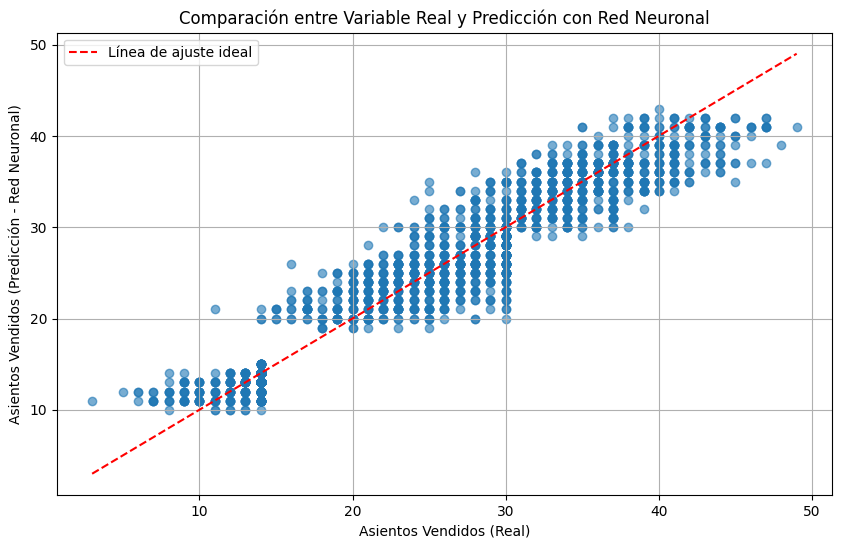

In [14]:
# Graficamos los resultados para comparar
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn_rounded, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', label='Línea de ajuste ideal')
plt.xlabel('Asientos Vendidos (Real)')
plt.ylabel('Asientos Vendidos (Predicción - Red Neuronal)')
plt.title('Comparación entre Variable Real y Predicción con Red Neuronal')
plt.legend()
plt.grid()
plt.show()

In [15]:
import pickle

# --- Guardado del modelo para despliegue ---

print("\nGuardando el preprocesador y el modelo entrenado...")


# Creamos un diccionario para contener todo lo necesario para el despliegue.
# Guardamos los pesos del modelo (state_dict) en lugar del objeto modelo completo.
deployment_package = {
    'input_features': input_features, # El número de características de entrada.
    'model_state_dict': model.state_dict(),
    'preprocessor': preprocessor
}

# Usamos pickle para guardar el diccionario en un único archivo binario (.pkl).
with open('demand_prediction_redN.pkl', 'wb') as f:
    pickle.dump(deployment_package, f)

print("El paquete de despliegue se ha guardado en 'demand_prediction_redN.pkl'")


Guardando el preprocesador y el modelo entrenado...
El paquete de despliegue se ha guardado en 'demand_prediction_redN.pkl'


### PROPHET

Instalamos la librería 'prophet' de Facebook (Meta).

Es especializada en series de tiempo con estacionalidad, ideal para estos dator y el ejercicio a realizar

In [16]:
!pip install prophet

Bucle para cada ruta

Prophet necesita columnas llamadas 'ds' para la fecha y 'y' para el valor. Además la columna 'ds' debe tener el formato datetime

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/8l2jqfnw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/kdm_xnsc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21159', 'data', 'file=/tmp/tmpuukp5bmj/8l2jqfnw.json', 'init=/tmp/tmpuukp5bmj/kdm_xnsc.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelf2soa1hq/prophet_model-20250703023547.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Se encontraron 25 rutas únicas. Iniciando procesamiento con Prophet...
--- Procesando Ruta: Lugar_A -> Lugar_A ---
Ruta Lugar_A -> Lugar_A - RMSE con Prophet: 26.31722683006964


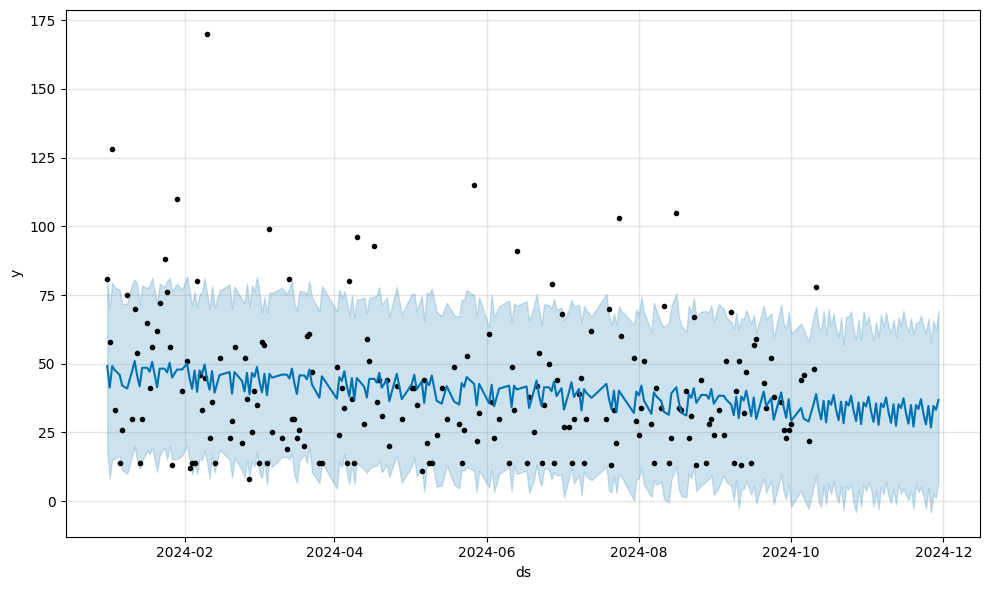

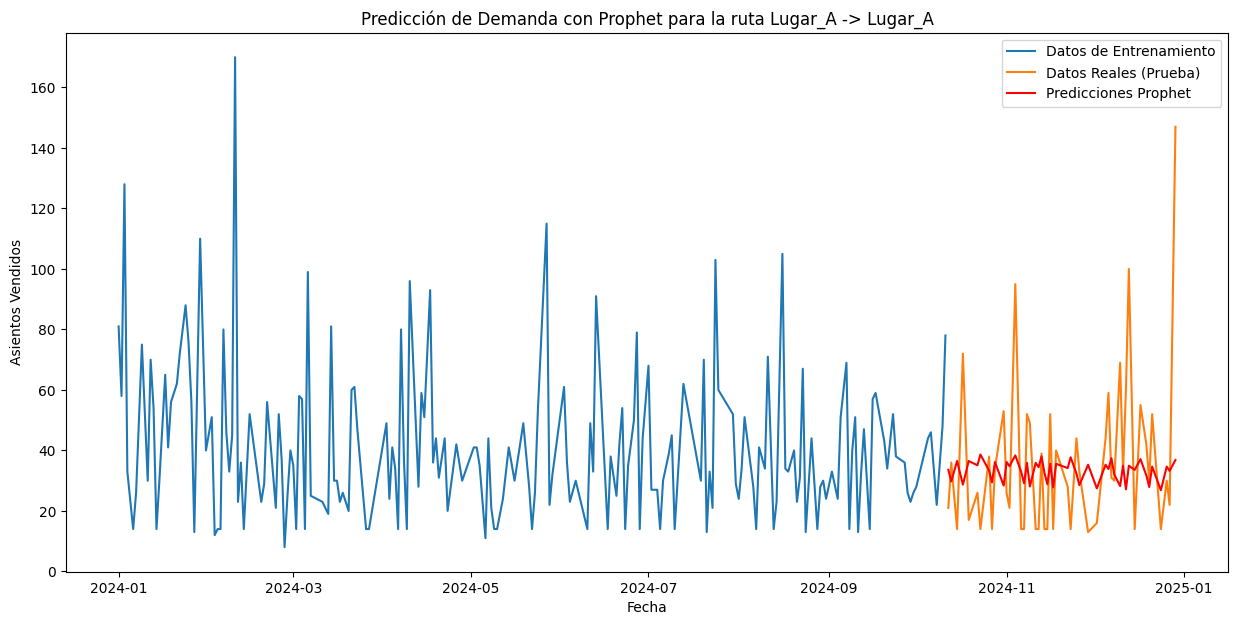

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/t5ba9bc4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/zduvx9m1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80387', 'data', 'file=/tmp/tmpuukp5bmj/t5ba9bc4.json', 'init=/tmp/tmpuukp5bmj/zduvx9m1.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelqzayzglx/prophet_model-20250703023548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_A -> Lugar_C ---
Ruta Lugar_A -> Lugar_C - RMSE con Prophet: 35.71198187651463


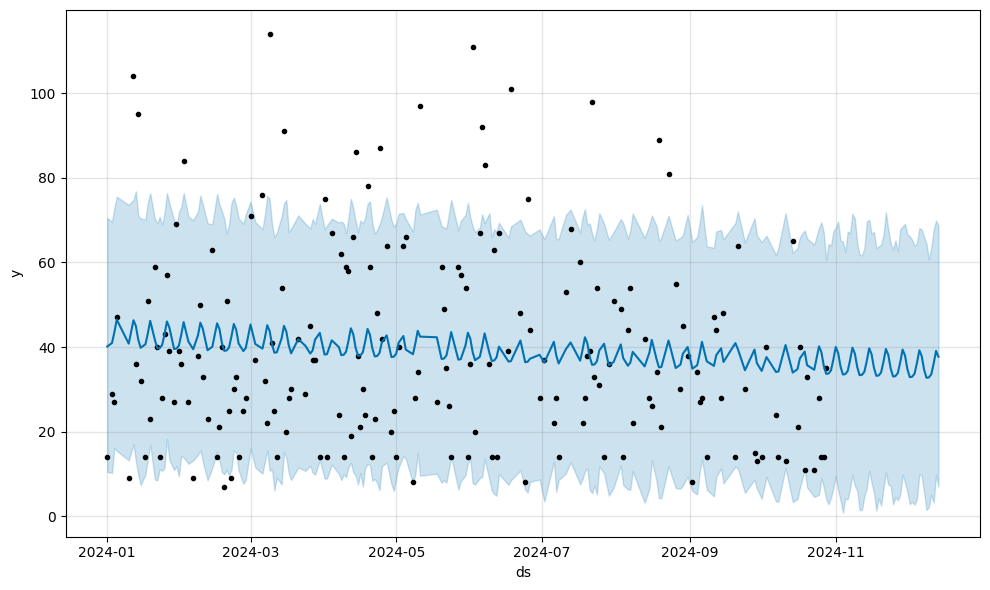

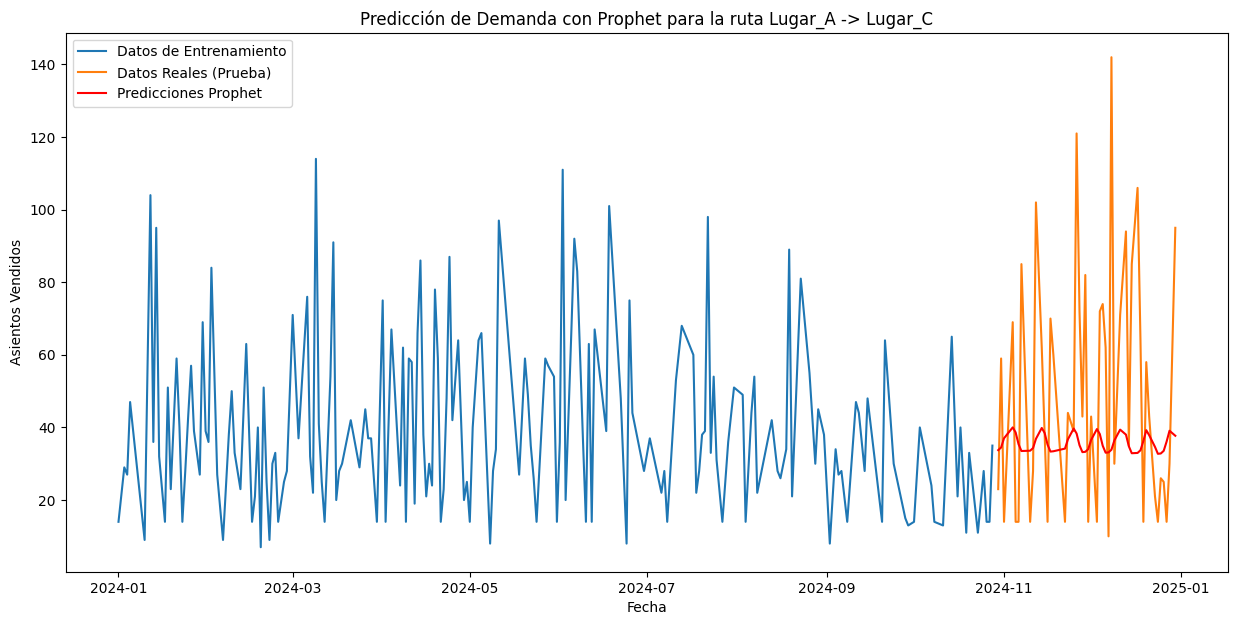

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/nu3_y9z7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/iuei4ulk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85279', 'data', 'file=/tmp/tmpuukp5bmj/nu3_y9z7.json', 'init=/tmp/tmpuukp5bmj/iuei4ulk.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelyzq22qm5/prophet_model-20250703023549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_A -> Lugar_D ---
Ruta Lugar_A -> Lugar_D - RMSE con Prophet: 33.03339322105094


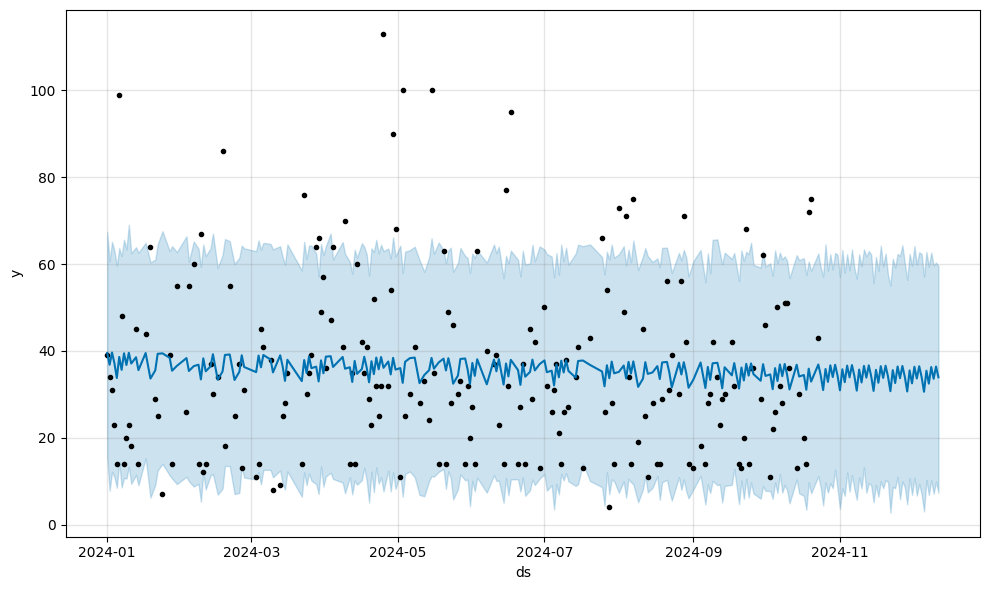

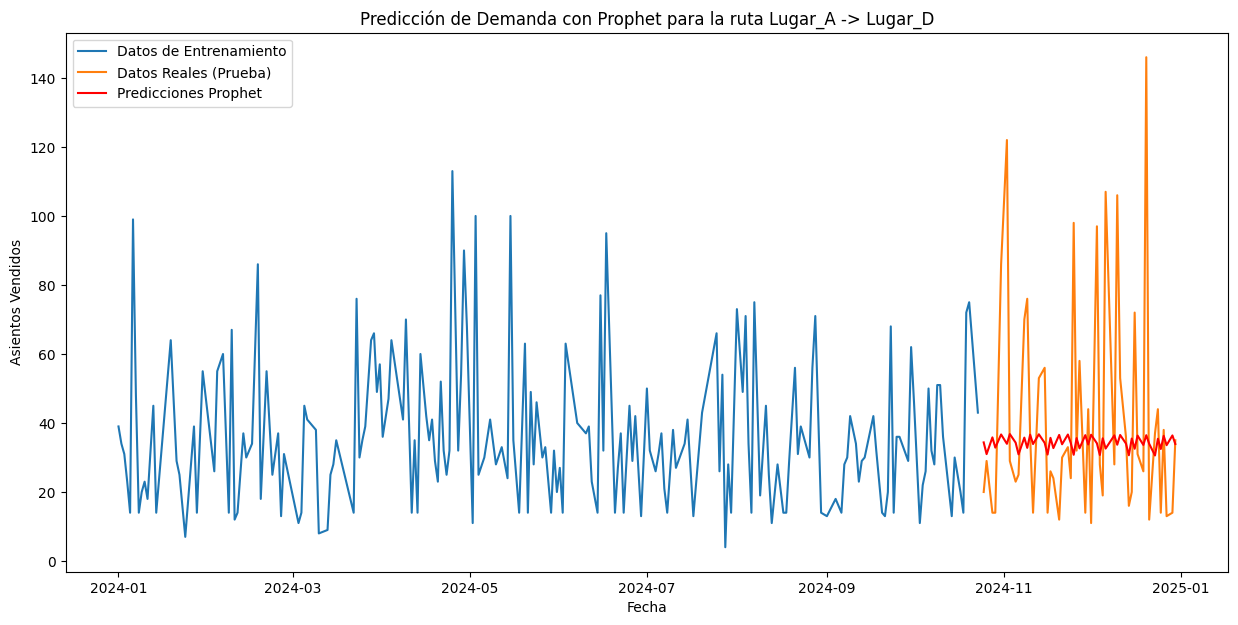

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/8eqr649_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/tvinhu7k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99803', 'data', 'file=/tmp/tmpuukp5bmj/8eqr649_.json', 'init=/tmp/tmpuukp5bmj/tvinhu7k.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelecqp722k/prophet_model-20250703023549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_A -> Lugar_E ---
Ruta Lugar_A -> Lugar_E - RMSE con Prophet: 23.258036901846125


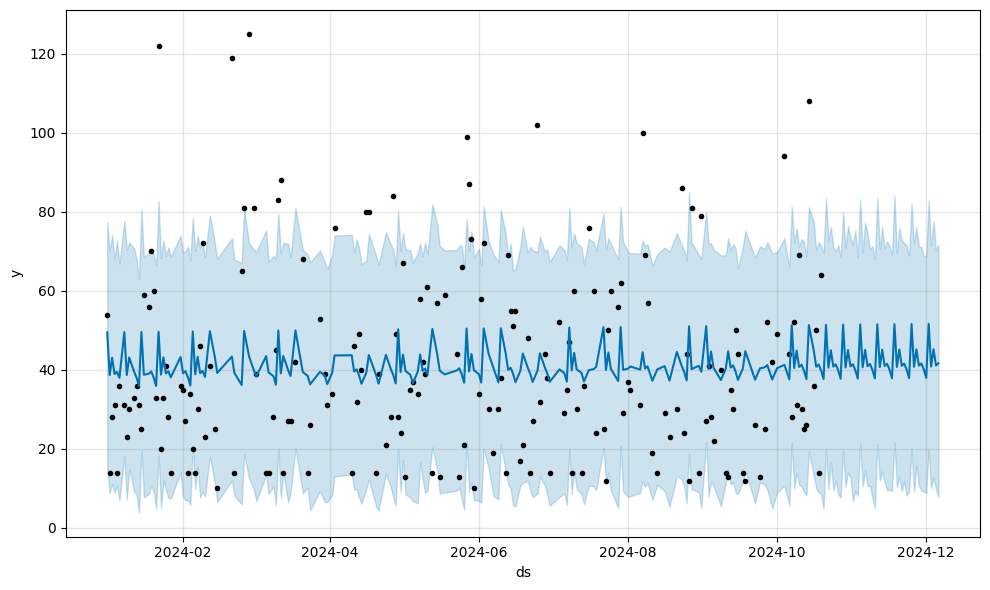

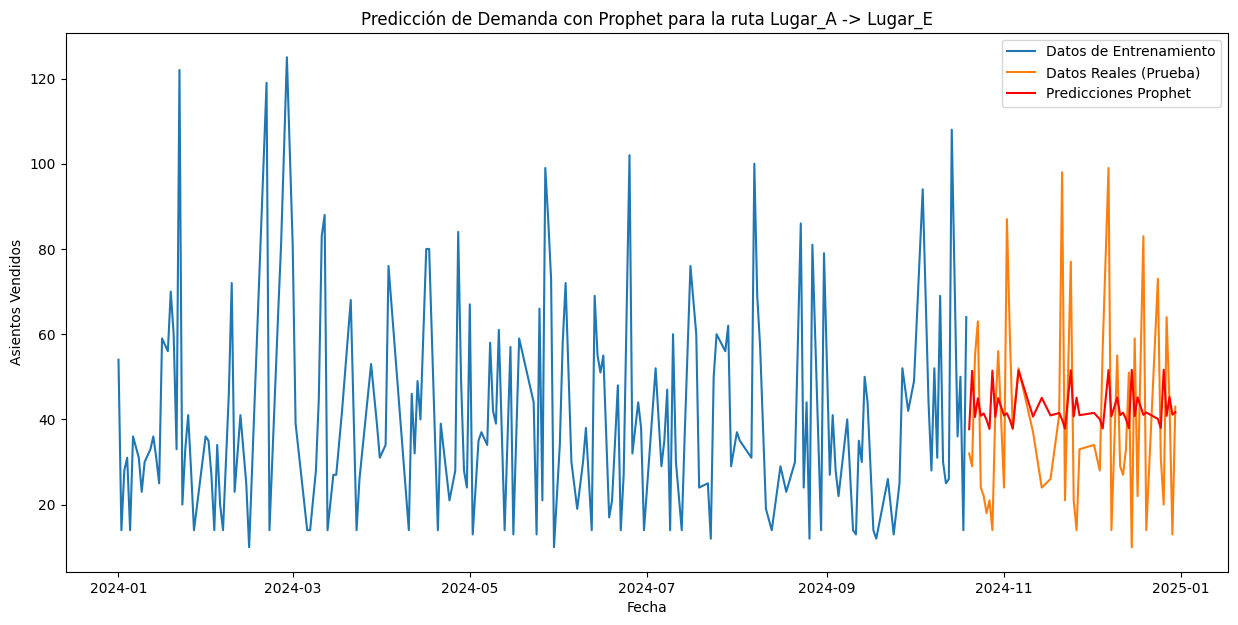

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/yw7t58de.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/7yiif6t5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37603', 'data', 'file=/tmp/tmpuukp5bmj/yw7t58de.json', 'init=/tmp/tmpuukp5bmj/7yiif6t5.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelr2_xdx3k/prophet_model-20250703023550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_B -> Lugar_A ---
Ruta Lugar_B -> Lugar_A - RMSE con Prophet: 22.381298858172002


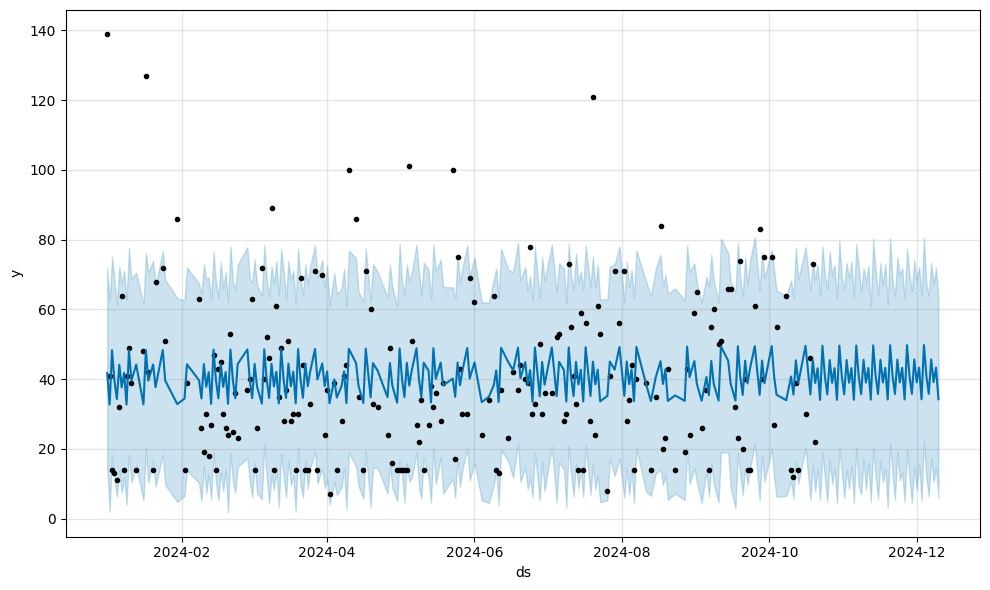

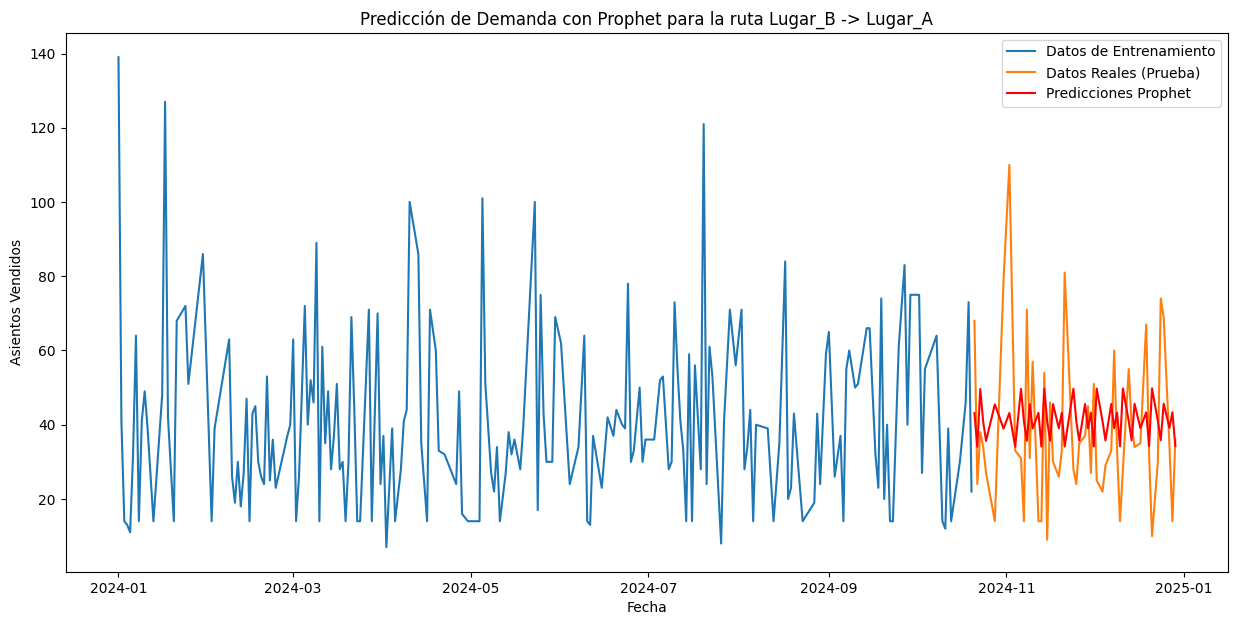

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/191qsxsl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/gknsja1l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52005', 'data', 'file=/tmp/tmpuukp5bmj/191qsxsl.json', 'init=/tmp/tmpuukp5bmj/gknsja1l.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modeld0fslr10/prophet_model-20250703023551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_B -> Lugar_B ---
Ruta Lugar_B -> Lugar_B - RMSE con Prophet: 23.508567367869034


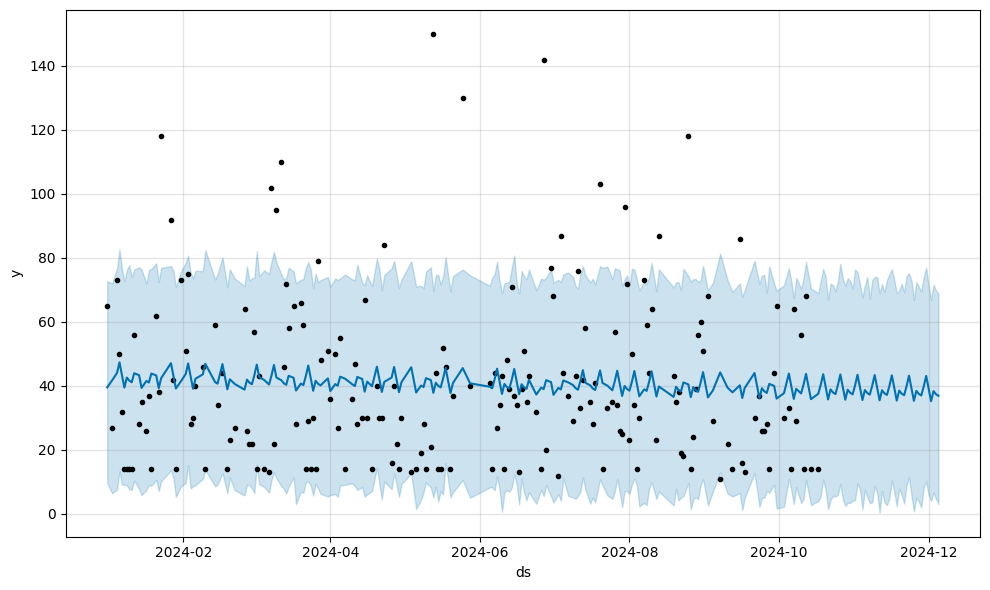

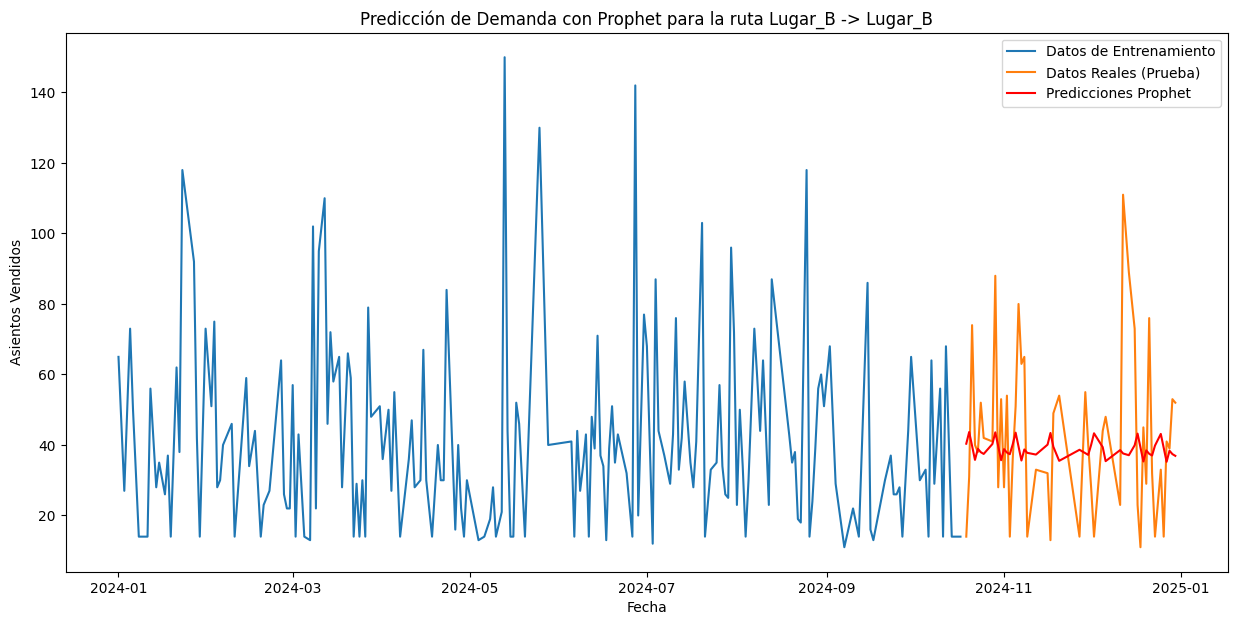

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/3cxw_f9g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/03lu6din.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68061', 'data', 'file=/tmp/tmpuukp5bmj/3cxw_f9g.json', 'init=/tmp/tmpuukp5bmj/03lu6din.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelitss_7xd/prophet_model-20250703023552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_B -> Lugar_C ---
Ruta Lugar_B -> Lugar_C - RMSE con Prophet: 23.53149385478826


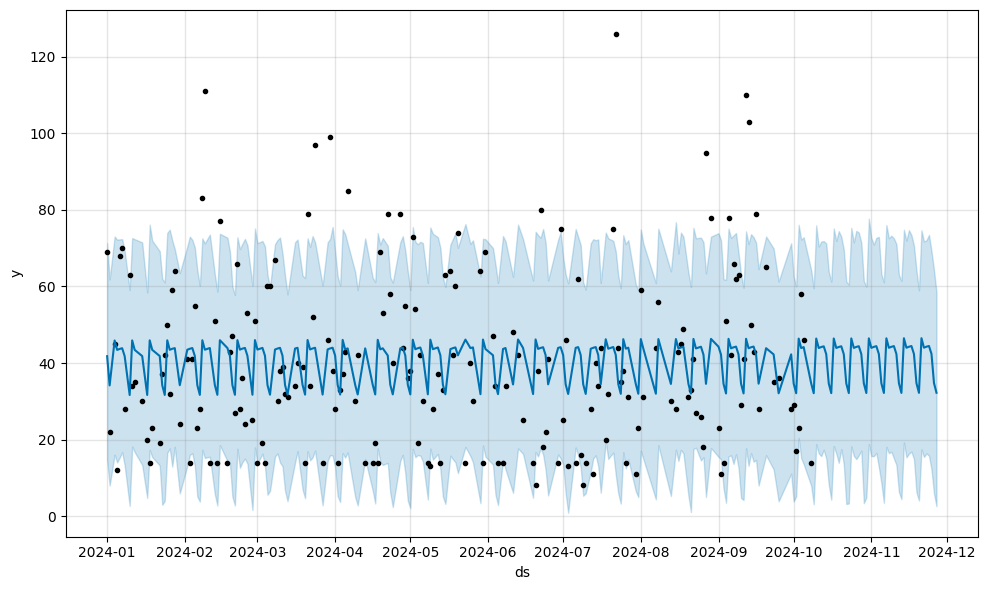

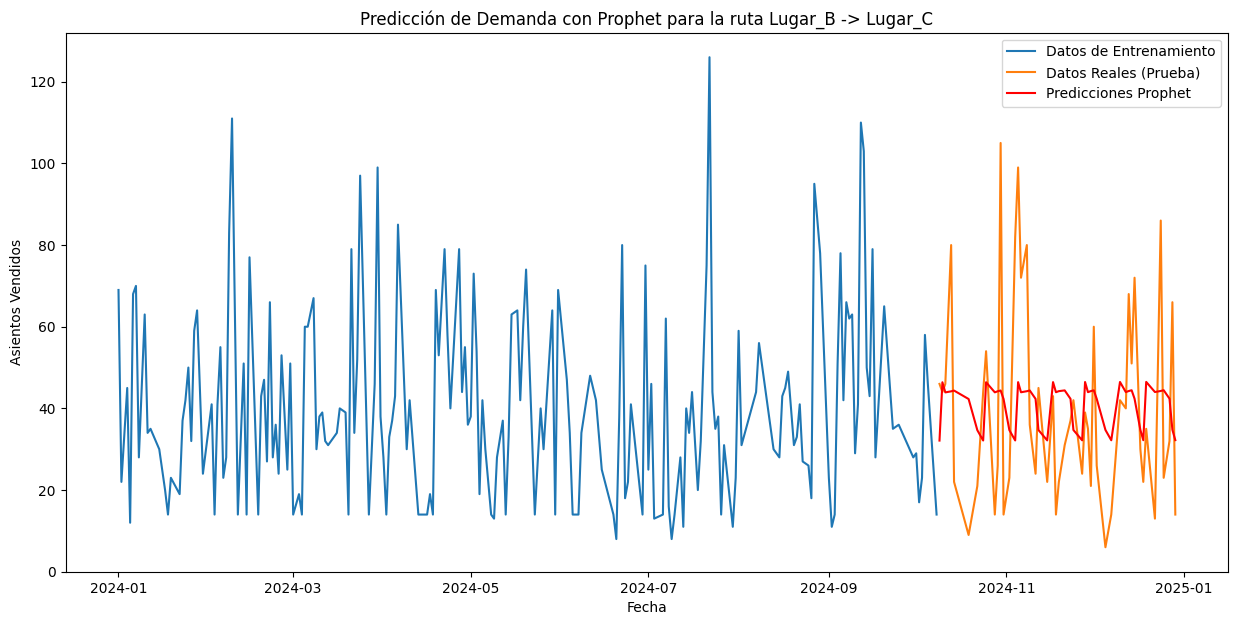

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/ejacz_4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/umc2m9ka.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5972', 'data', 'file=/tmp/tmpuukp5bmj/ejacz_4u.json', 'init=/tmp/tmpuukp5bmj/umc2m9ka.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelequ916lv/prophet_model-20250703023553.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_B -> Lugar_D ---
Ruta Lugar_B -> Lugar_D - RMSE con Prophet: 21.205662767747544


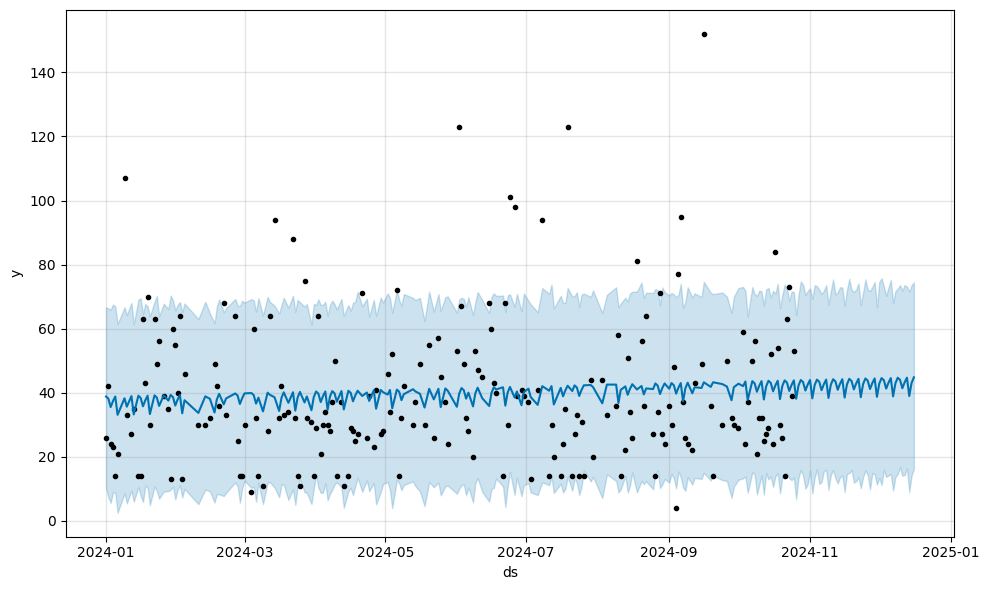

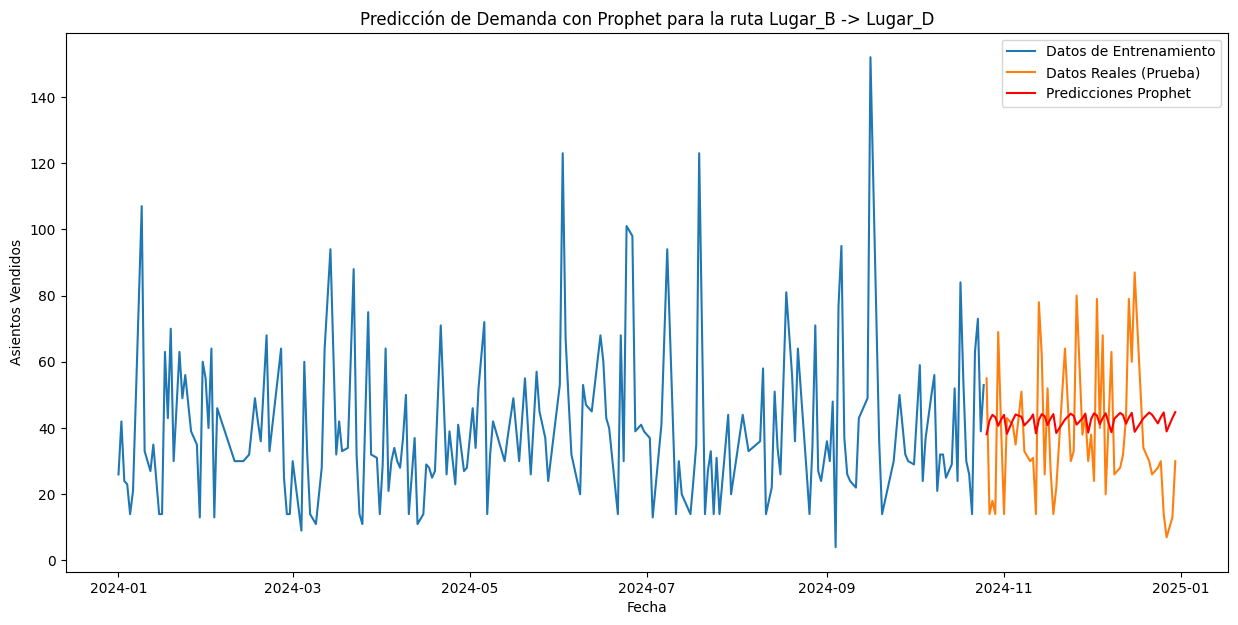

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/kqmvrqo4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/ymo5j7se.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97031', 'data', 'file=/tmp/tmpuukp5bmj/kqmvrqo4.json', 'init=/tmp/tmpuukp5bmj/ymo5j7se.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_model4899egfh/prophet_model-20250703023554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_B -> Lugar_E ---
Ruta Lugar_B -> Lugar_E - RMSE con Prophet: 22.53358372725866


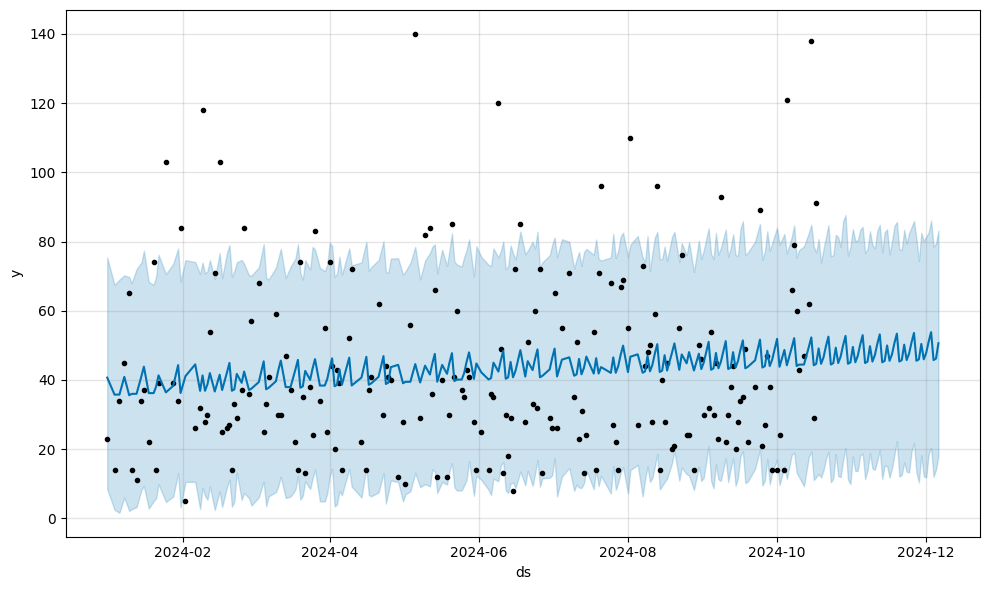

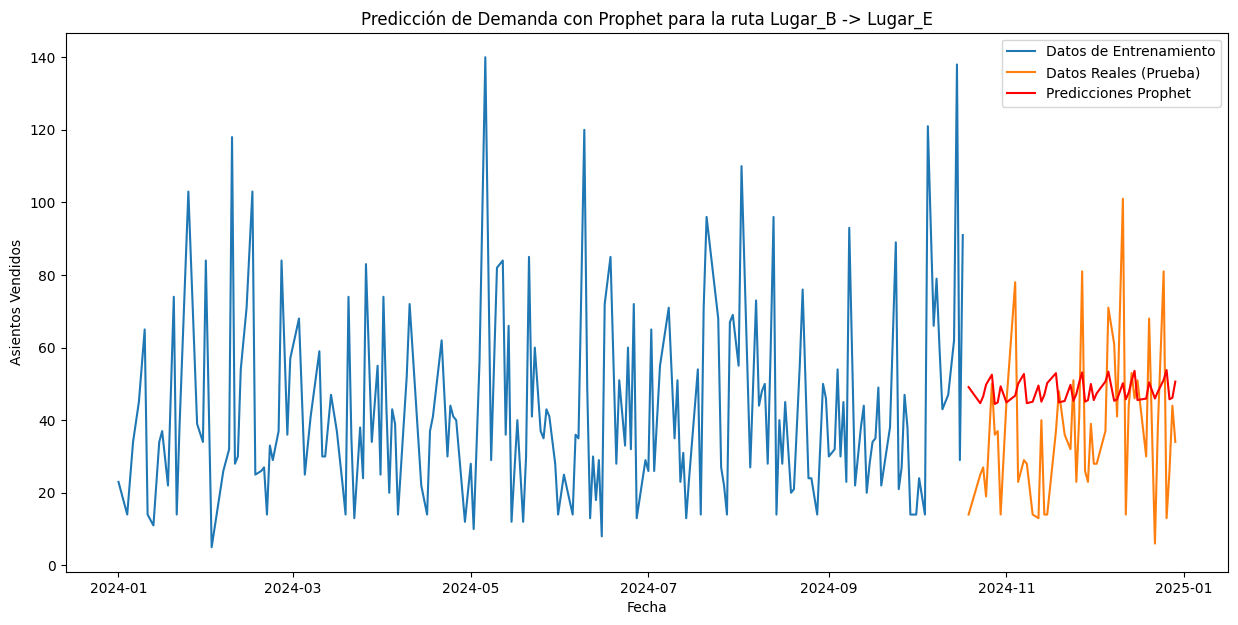

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/1i63lajw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/6gl34saw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69174', 'data', 'file=/tmp/tmpuukp5bmj/1i63lajw.json', 'init=/tmp/tmpuukp5bmj/6gl34saw.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelwnrzc5ns/prophet_model-20250703023555.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_C -> Lugar_A ---
Ruta Lugar_C -> Lugar_A - RMSE con Prophet: 25.79645834946618


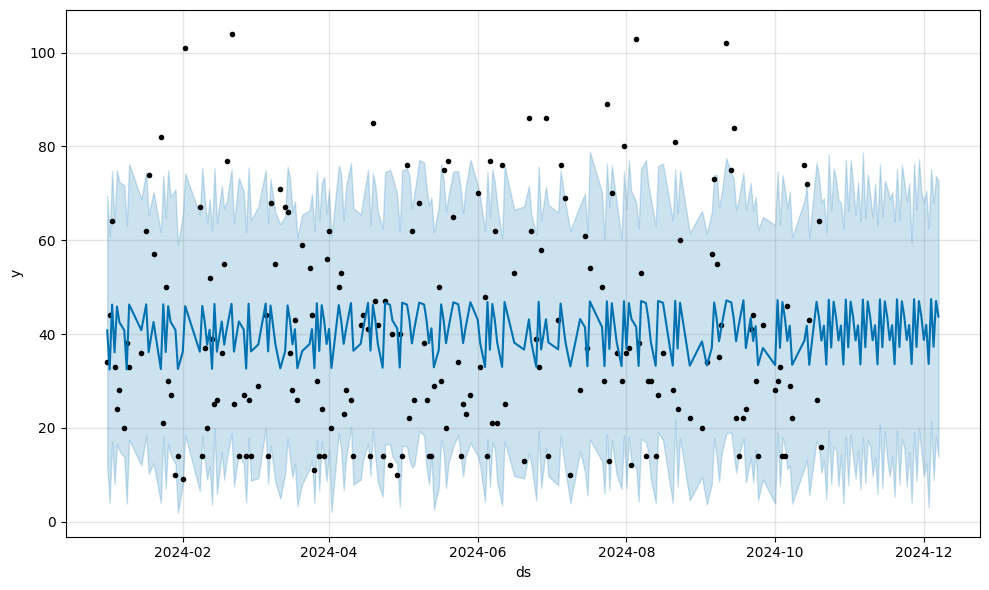

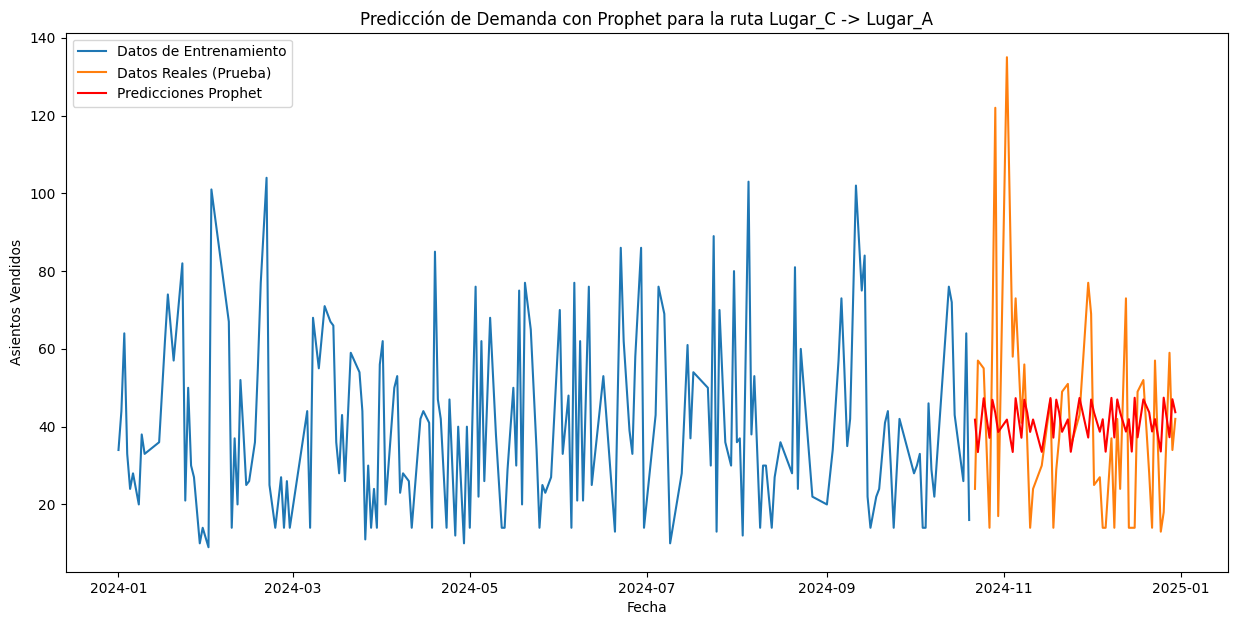

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/woyozbav.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/7n6opter.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63384', 'data', 'file=/tmp/tmpuukp5bmj/woyozbav.json', 'init=/tmp/tmpuukp5bmj/7n6opter.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelnullxfm_/prophet_model-20250703023556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_C -> Lugar_C ---
Ruta Lugar_C -> Lugar_C - RMSE con Prophet: 27.33683126376013


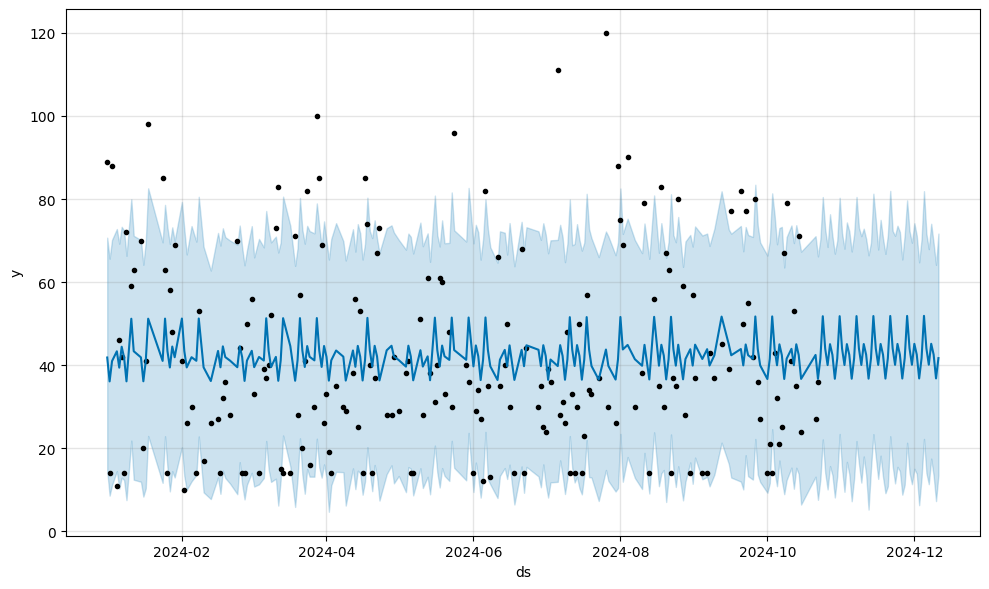

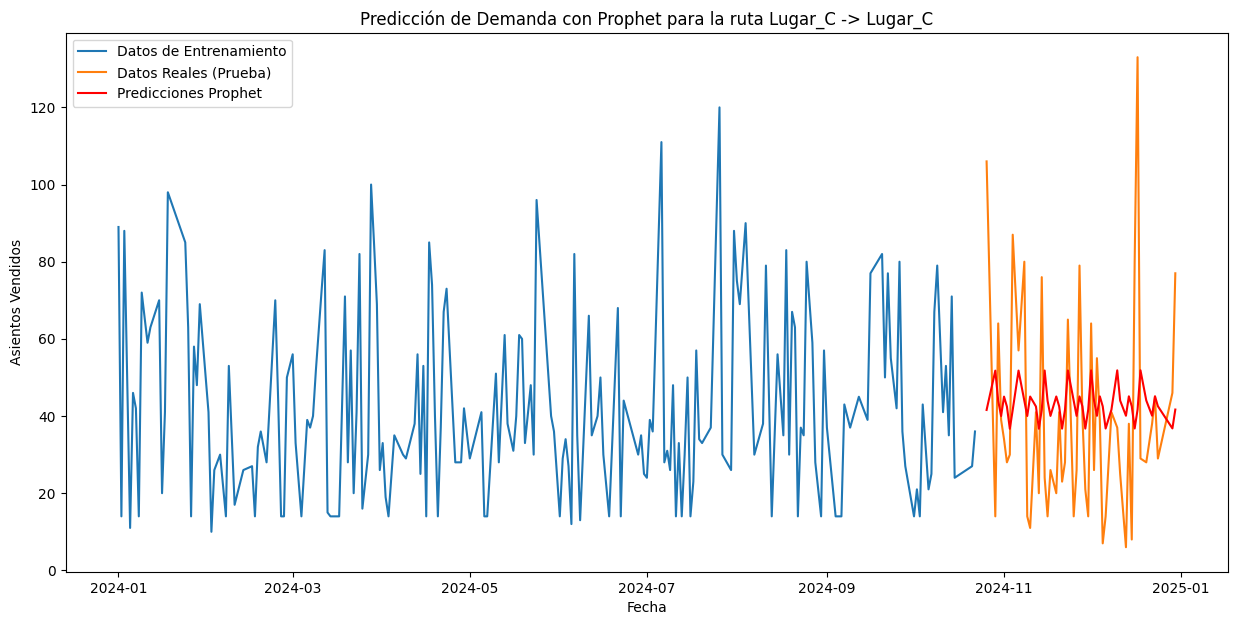

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/jw5_89hy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/smr7wv8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9645', 'data', 'file=/tmp/tmpuukp5bmj/jw5_89hy.json', 'init=/tmp/tmpuukp5bmj/smr7wv8d.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_model_43616_b/prophet_model-20250703023557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_D -> Lugar_A ---
Ruta Lugar_D -> Lugar_A - RMSE con Prophet: 21.585784545585195


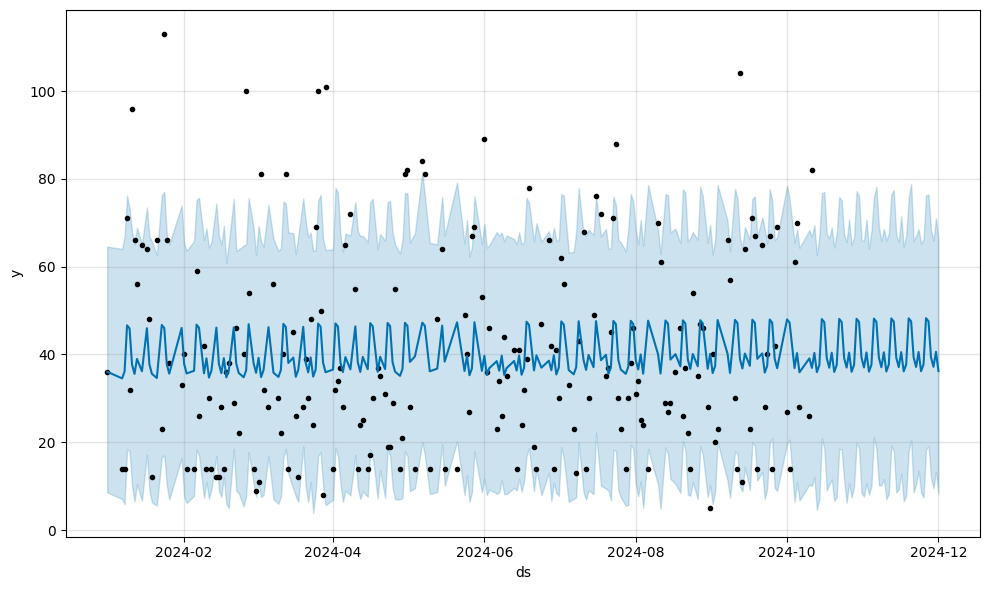

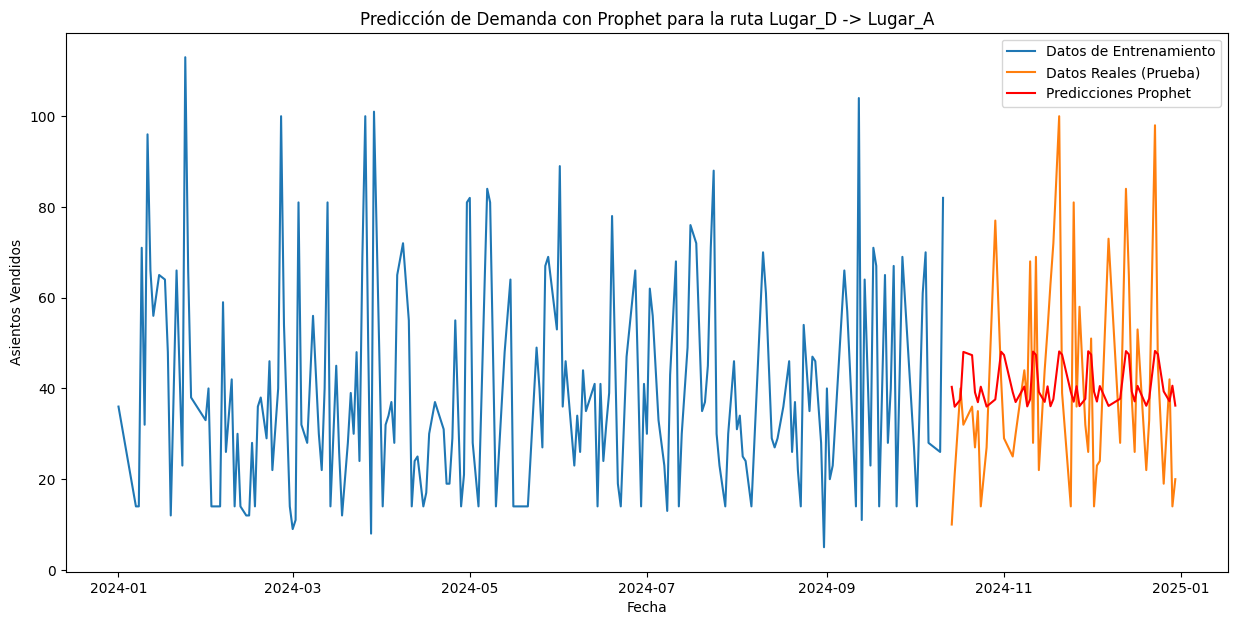

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/20xjd_ch.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/c7dknjel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83230', 'data', 'file=/tmp/tmpuukp5bmj/20xjd_ch.json', 'init=/tmp/tmpuukp5bmj/c7dknjel.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_model0u4o0o7k/prophet_model-20250703023558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_D -> Lugar_D ---
Ruta Lugar_D -> Lugar_D - RMSE con Prophet: 22.94667826991398


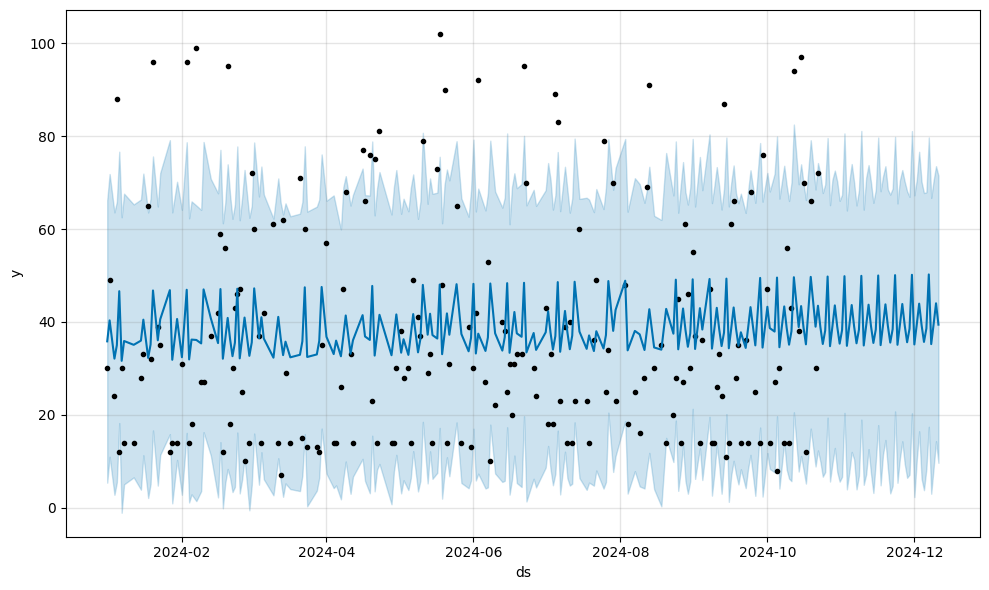

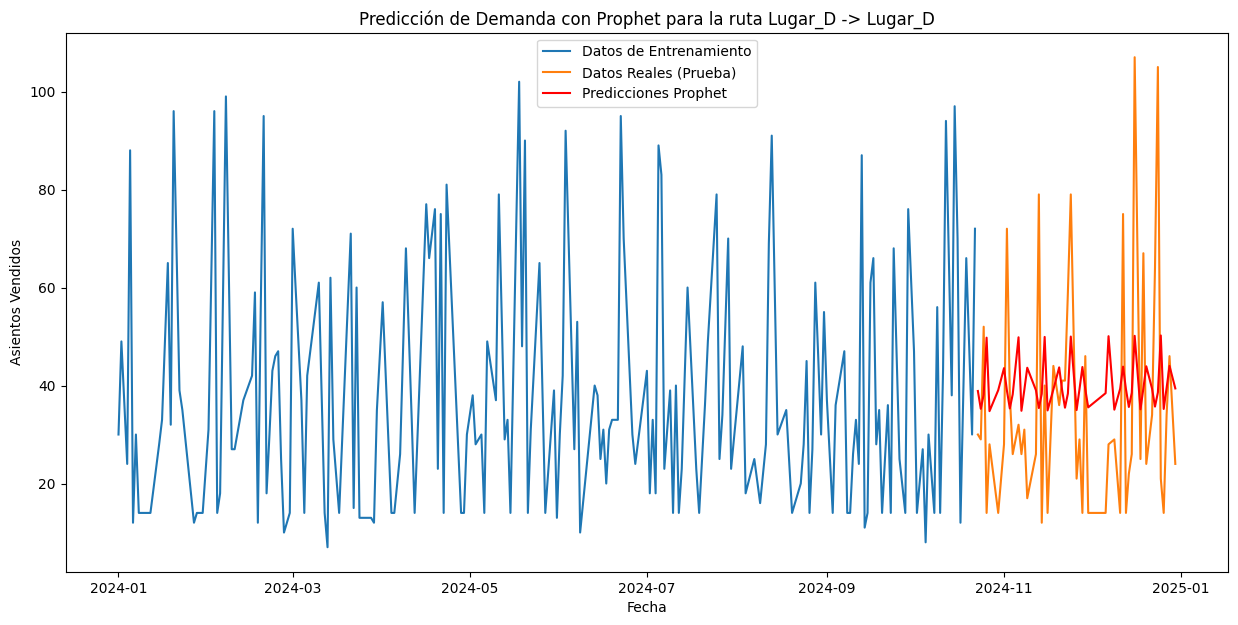

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/__bg4uve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/wh3x3y3m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12251', 'data', 'file=/tmp/tmpuukp5bmj/__bg4uve.json', 'init=/tmp/tmpuukp5bmj/wh3x3y3m.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modeldrks081_/prophet_model-20250703023559.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:35:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:35:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_D -> Lugar_E ---
Ruta Lugar_D -> Lugar_E - RMSE con Prophet: 23.173433965681177


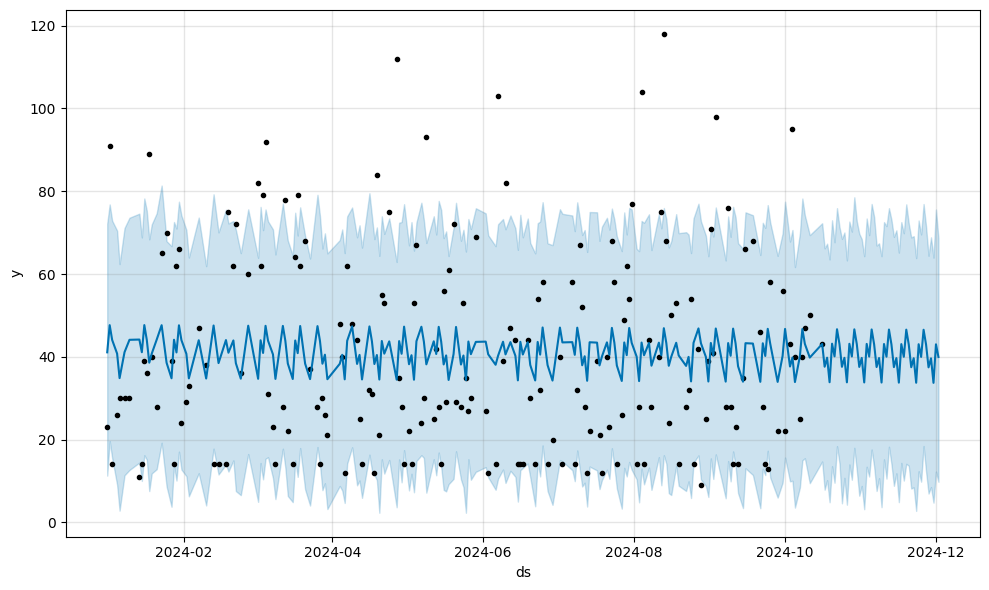

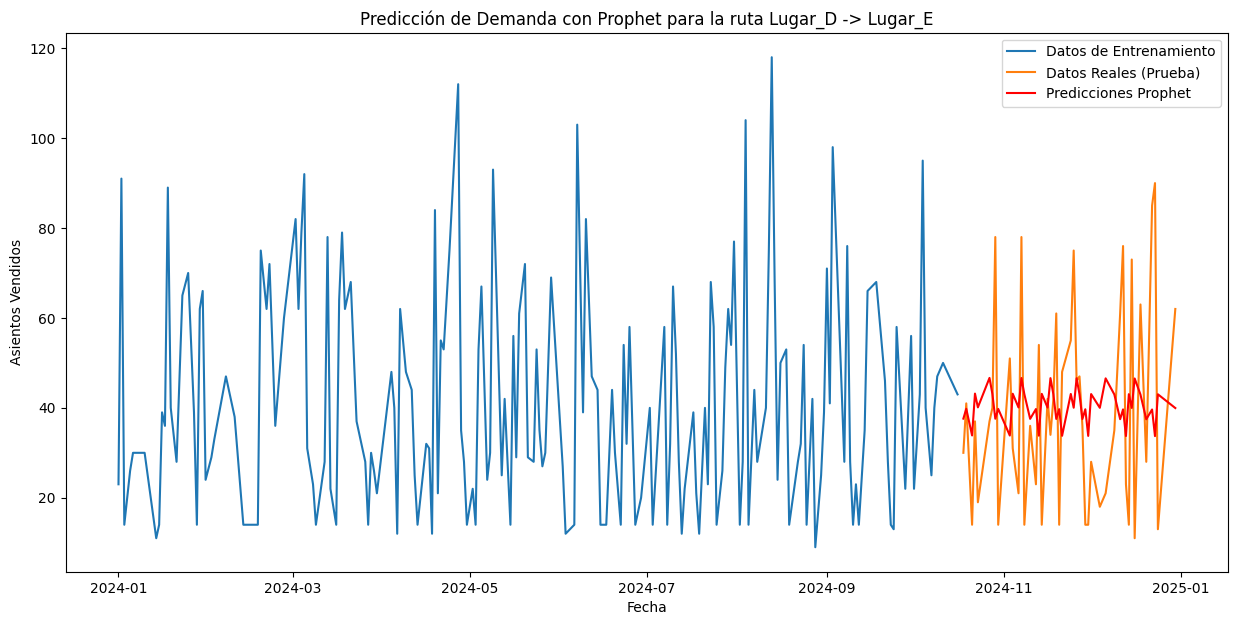

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/aw70b0ia.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/p6cr699z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20445', 'data', 'file=/tmp/tmpuukp5bmj/aw70b0ia.json', 'init=/tmp/tmpuukp5bmj/p6cr699z.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modeli14c_ojf/prophet_model-20250703023600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_E -> Lugar_A ---
Ruta Lugar_E -> Lugar_A - RMSE con Prophet: 29.344701627009936


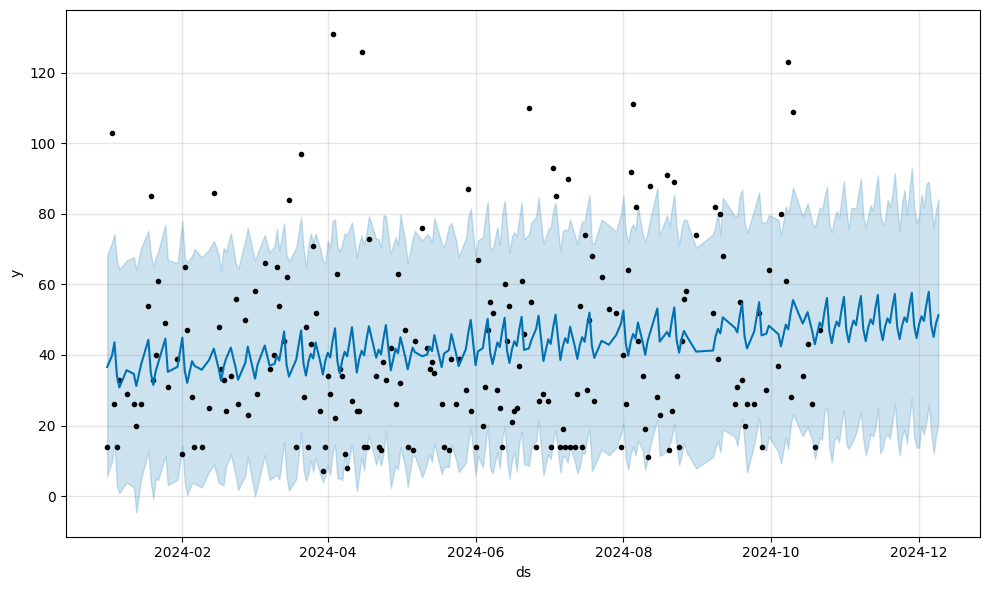

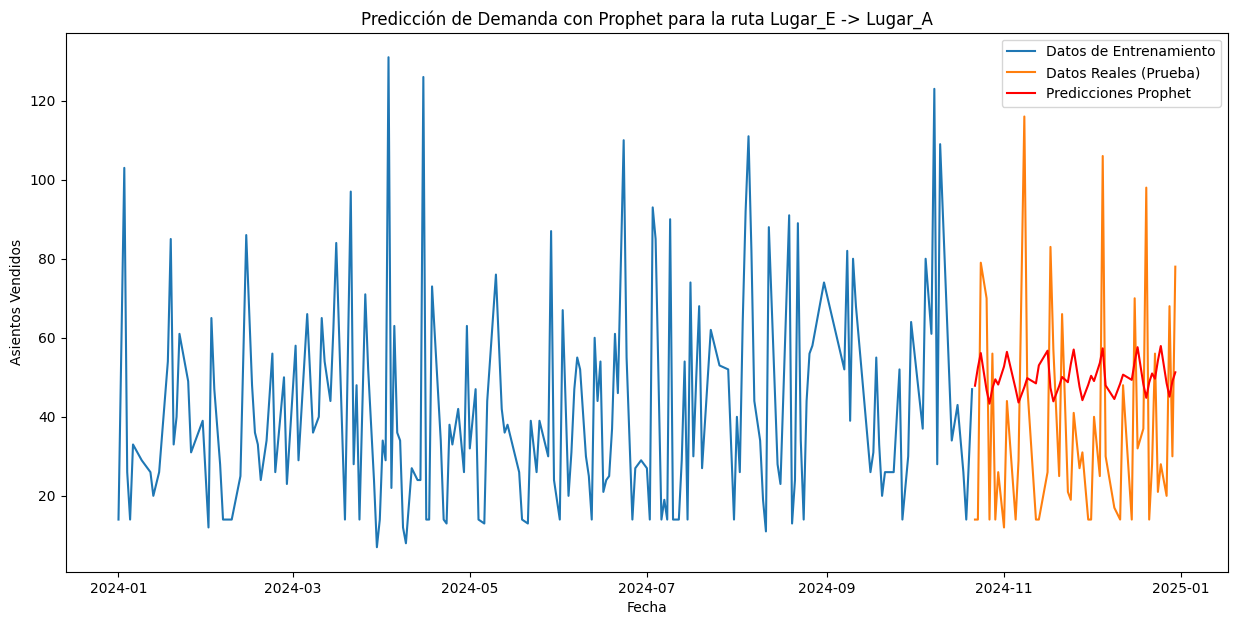

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/mf4b7he0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/tgtpvi80.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44074', 'data', 'file=/tmp/tmpuukp5bmj/mf4b7he0.json', 'init=/tmp/tmpuukp5bmj/tgtpvi80.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelol596co8/prophet_model-20250703023601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_E -> Lugar_B ---
Ruta Lugar_E -> Lugar_B - RMSE con Prophet: 22.40025104950182


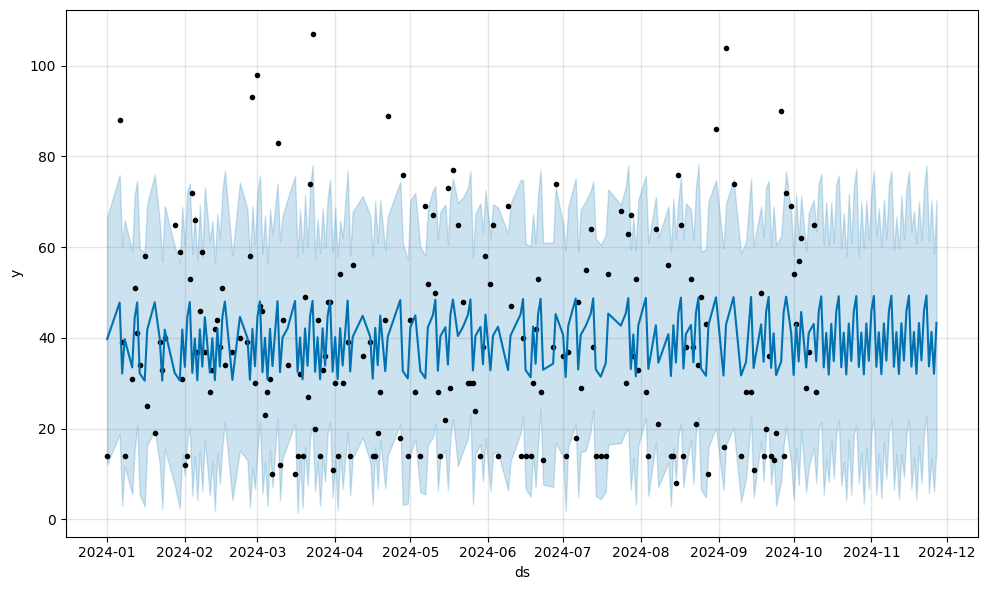

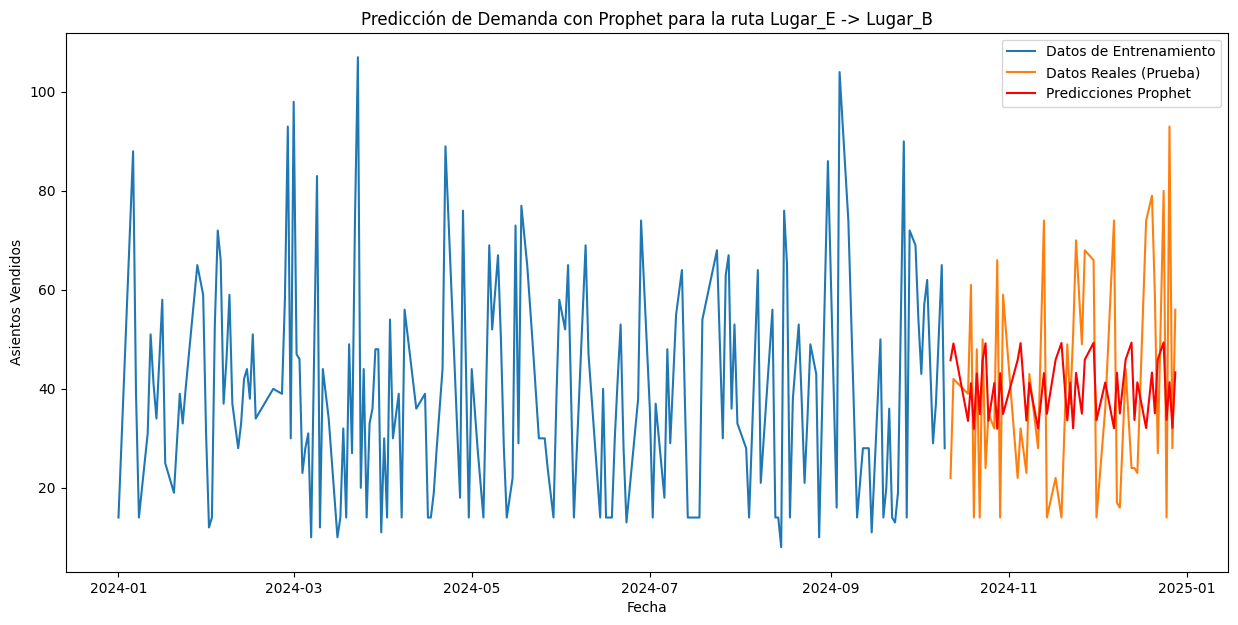

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/fgk5e4jf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/fwabzz91.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64870', 'data', 'file=/tmp/tmpuukp5bmj/fgk5e4jf.json', 'init=/tmp/tmpuukp5bmj/fwabzz91.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modellym1zyev/prophet_model-20250703023604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_E -> Lugar_D ---
Ruta Lugar_E -> Lugar_D - RMSE con Prophet: 28.889136947703346


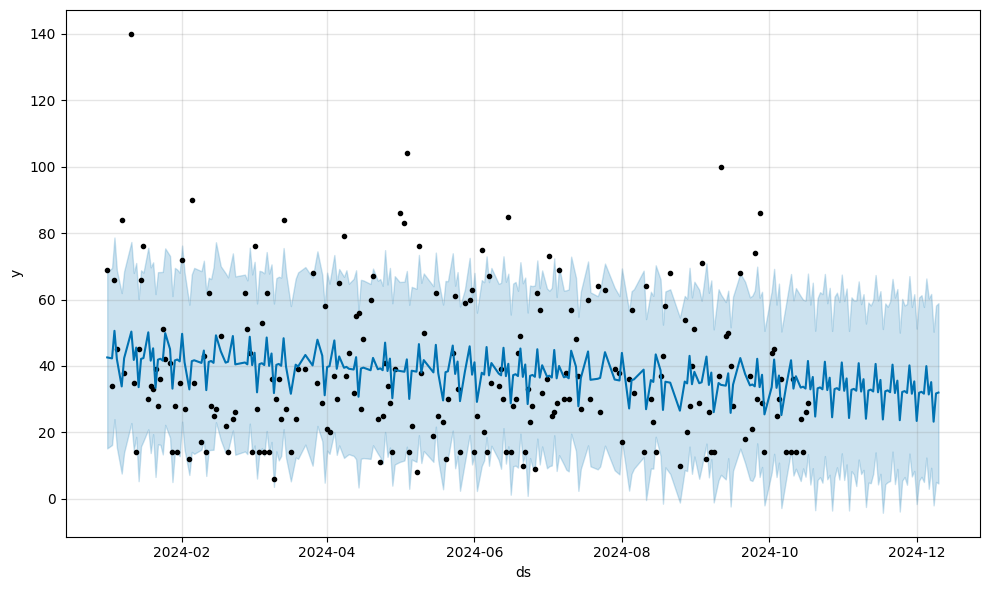

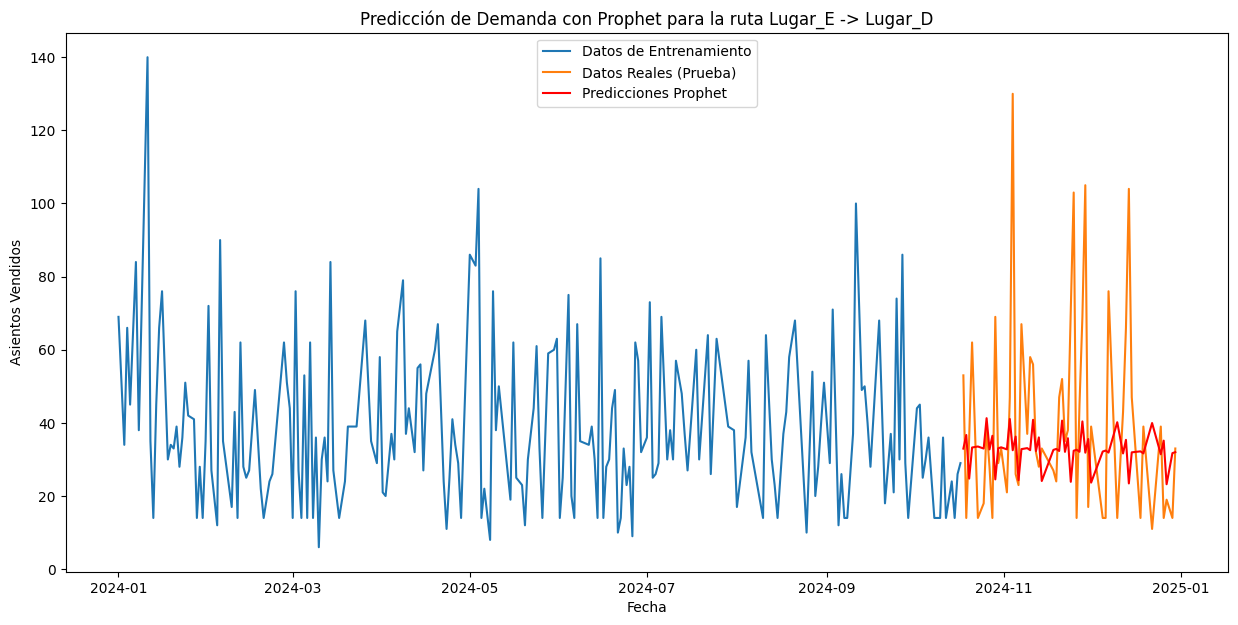

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/4blqyh8n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/ntz_6wds.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68169', 'data', 'file=/tmp/tmpuukp5bmj/4blqyh8n.json', 'init=/tmp/tmpuukp5bmj/ntz_6wds.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modeldlm9fvma/prophet_model-20250703023604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_A -> Lugar_B ---
Ruta Lugar_A -> Lugar_B - RMSE con Prophet: 27.360901195715023


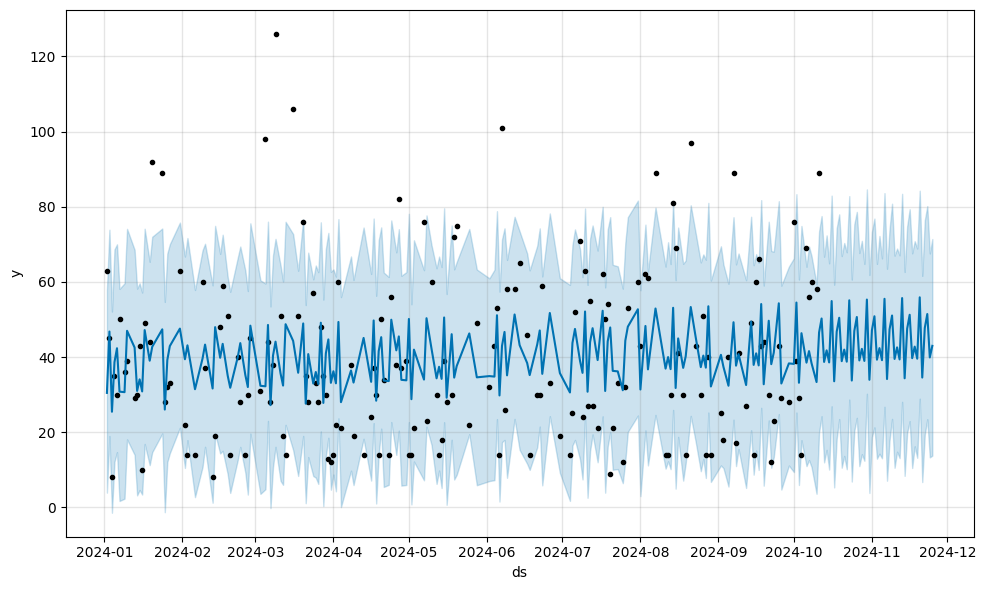

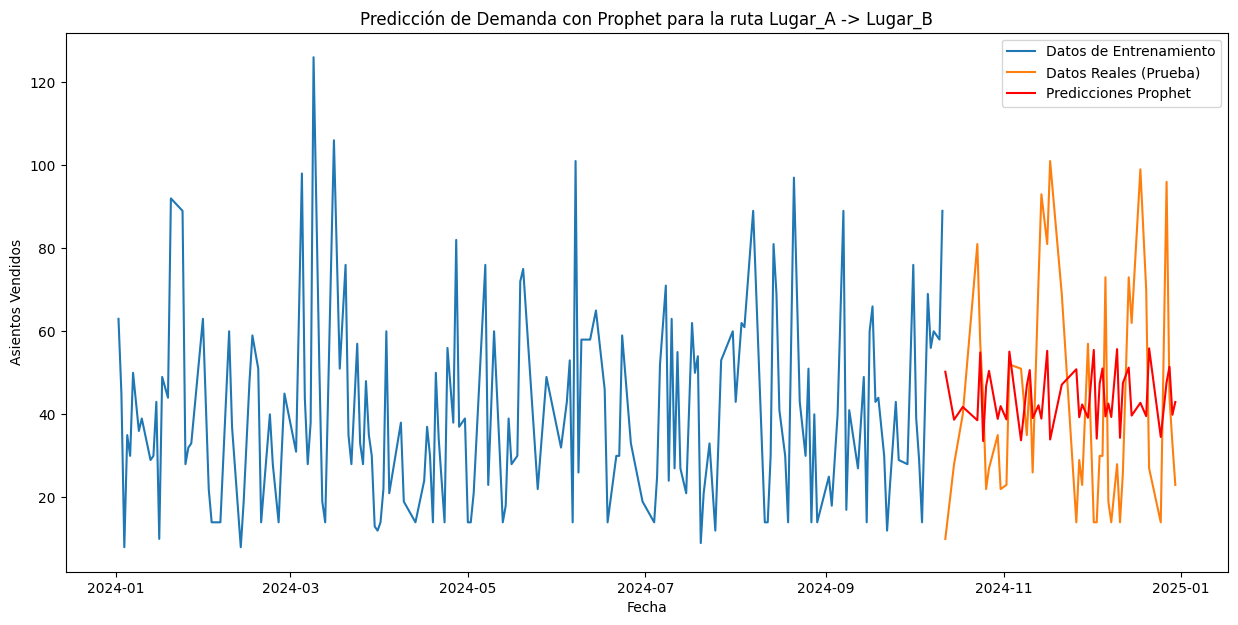

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/61bz23f4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/4abu_5sn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37703', 'data', 'file=/tmp/tmpuukp5bmj/61bz23f4.json', 'init=/tmp/tmpuukp5bmj/4abu_5sn.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelzc7leksc/prophet_model-20250703023606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_C -> Lugar_D ---
Ruta Lugar_C -> Lugar_D - RMSE con Prophet: 25.808900055870268


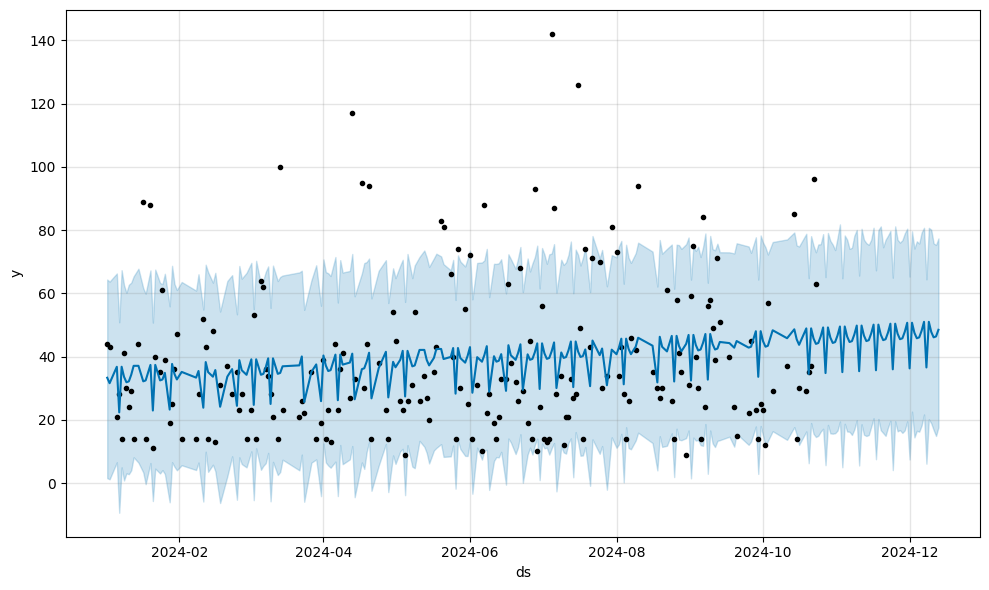

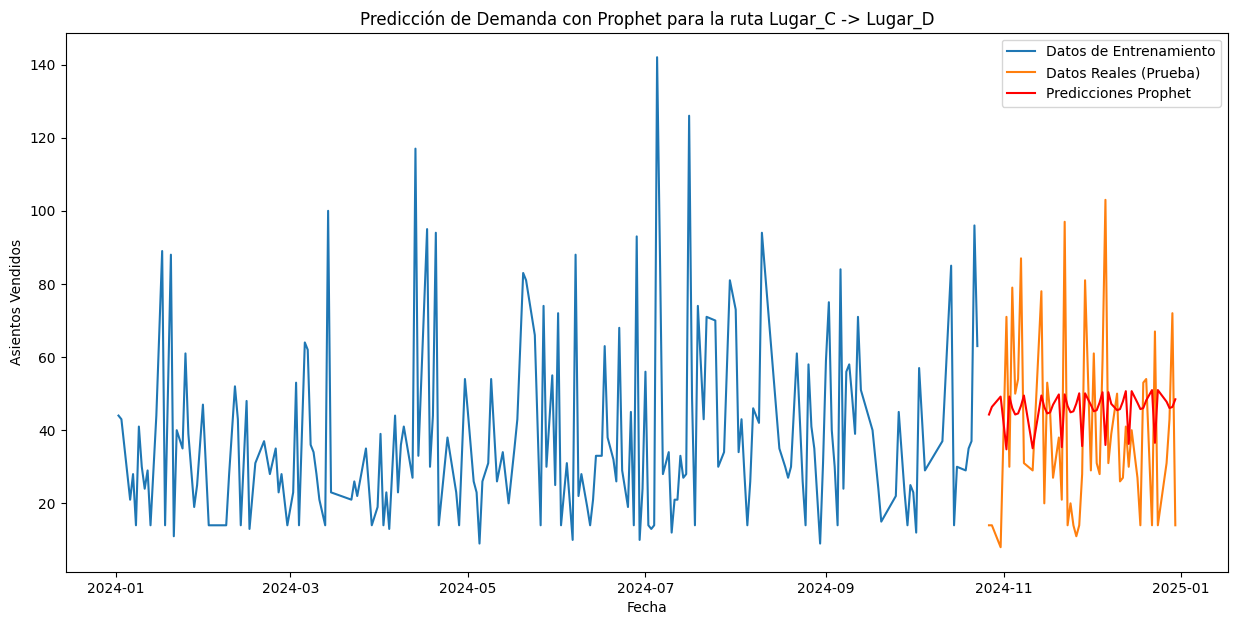

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/0lbzd5i1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/hfeg__q8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16543', 'data', 'file=/tmp/tmpuukp5bmj/0lbzd5i1.json', 'init=/tmp/tmpuukp5bmj/hfeg__q8.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_model8x0tq8ke/prophet_model-20250703023607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_C -> Lugar_E ---
Ruta Lugar_C -> Lugar_E - RMSE con Prophet: 23.80582353987665


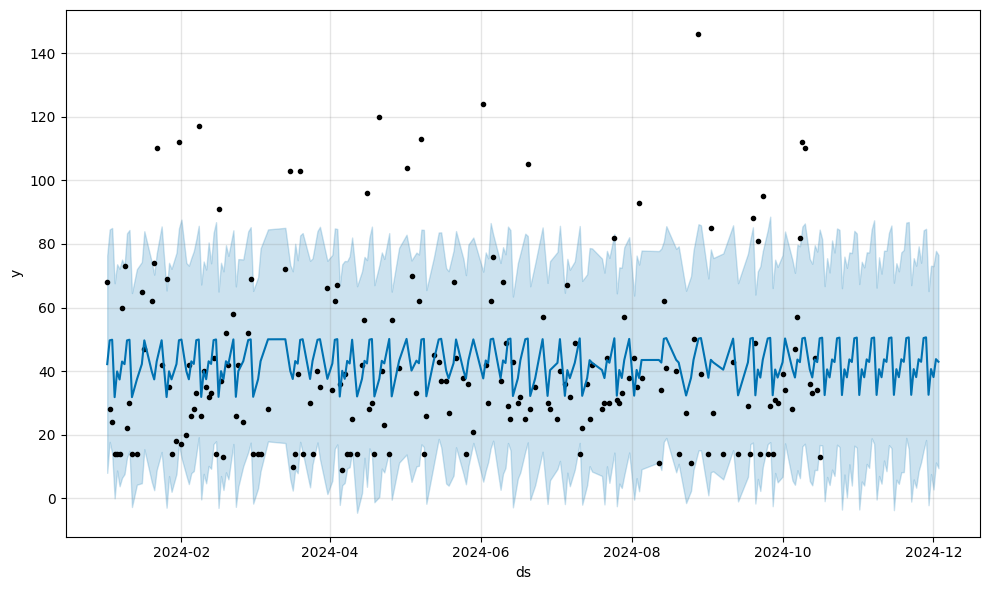

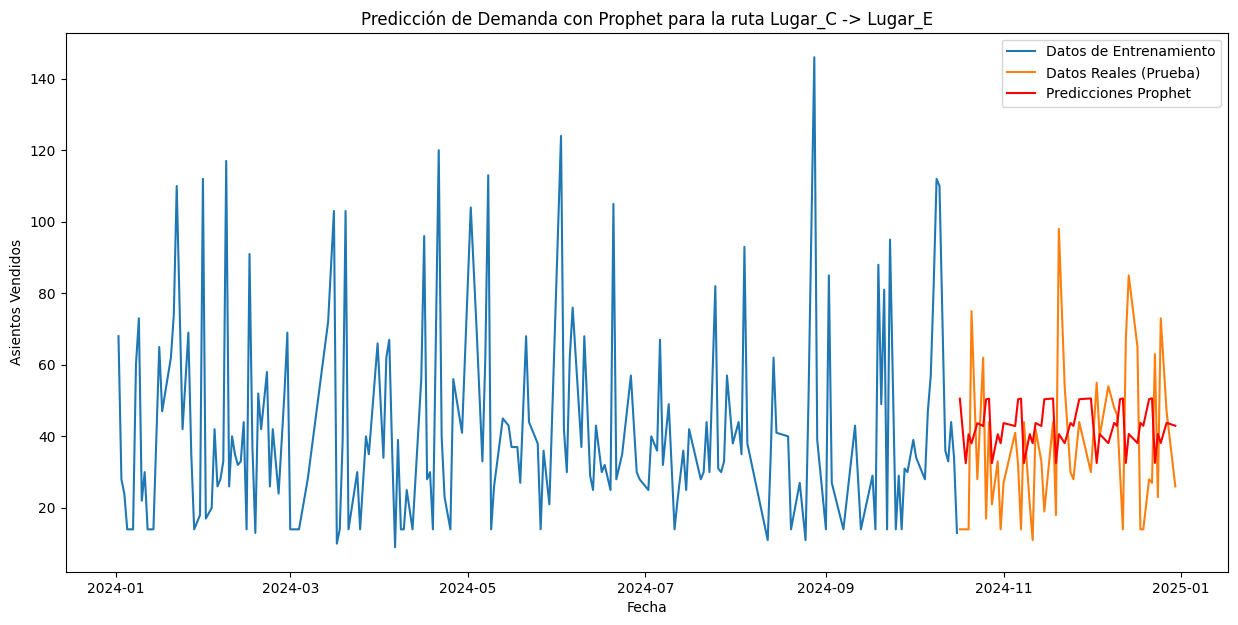

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/spvjb3rj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/uz2jc_sc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45555', 'data', 'file=/tmp/tmpuukp5bmj/spvjb3rj.json', 'init=/tmp/tmpuukp5bmj/uz2jc_sc.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_model73so3s5u/prophet_model-20250703023607.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_D -> Lugar_B ---
Ruta Lugar_D -> Lugar_B - RMSE con Prophet: 27.32414702163577


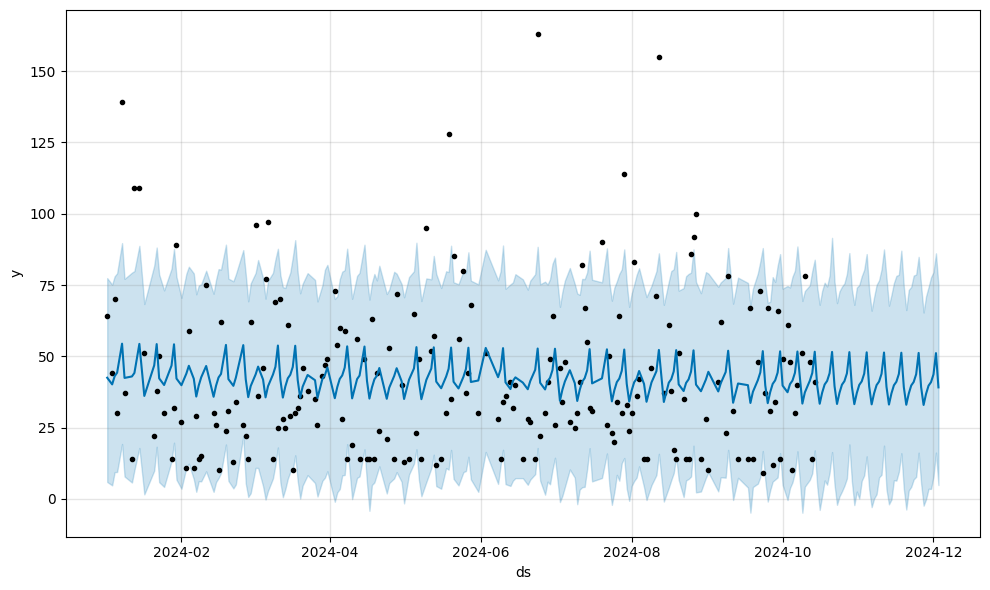

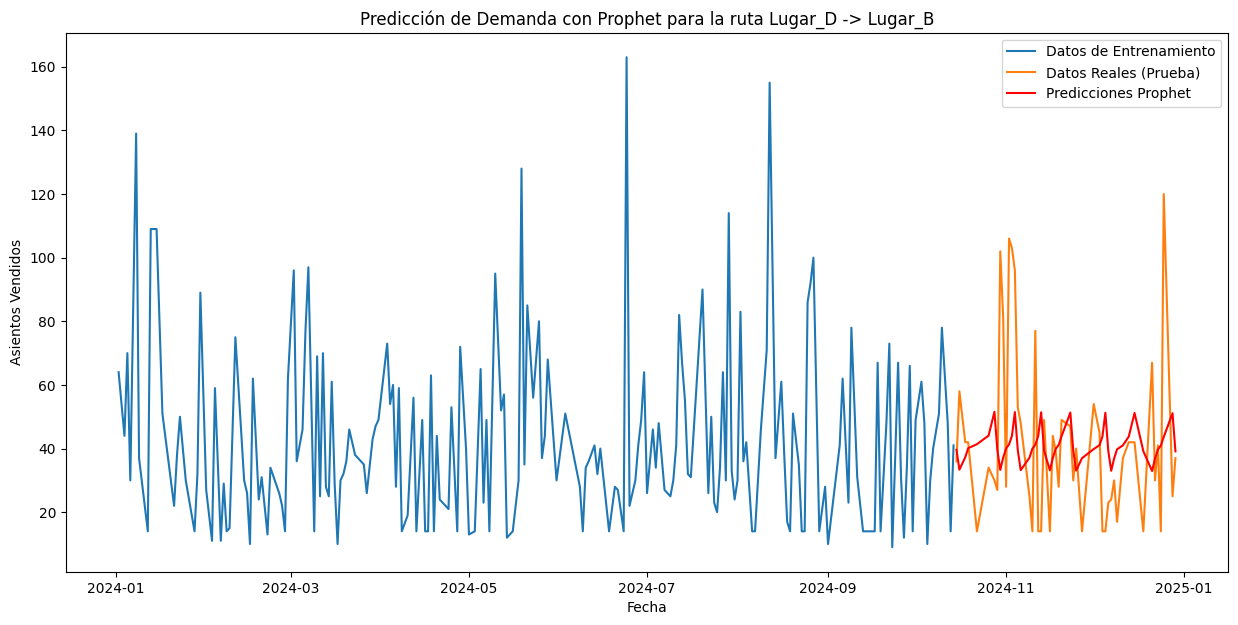

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/kijhmvhh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/itghtjiq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15724', 'data', 'file=/tmp/tmpuukp5bmj/kijhmvhh.json', 'init=/tmp/tmpuukp5bmj/itghtjiq.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelaeinxa68/prophet_model-20250703023608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_D -> Lugar_C ---
Ruta Lugar_D -> Lugar_C - RMSE con Prophet: 24.307369139601946


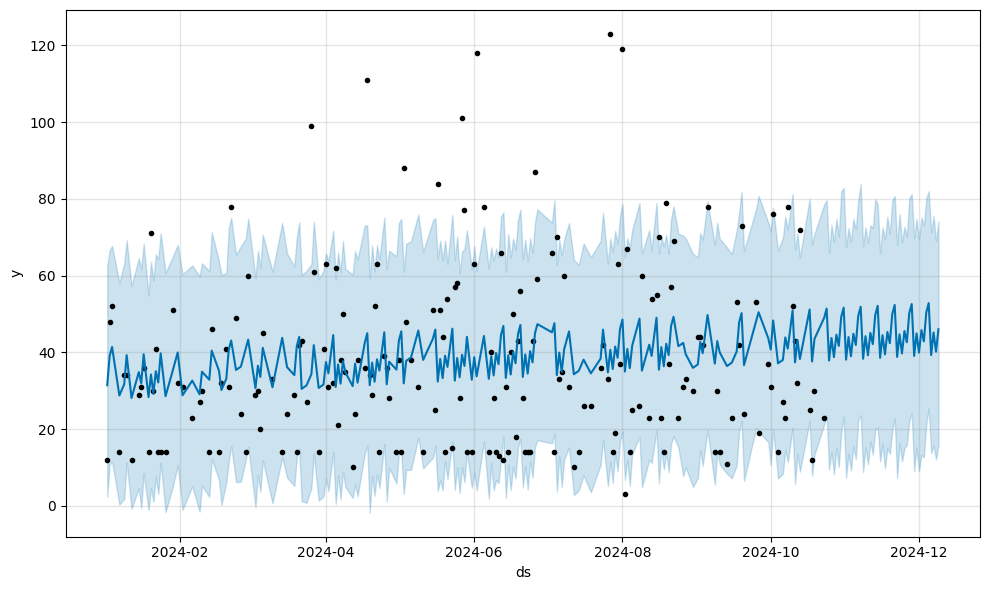

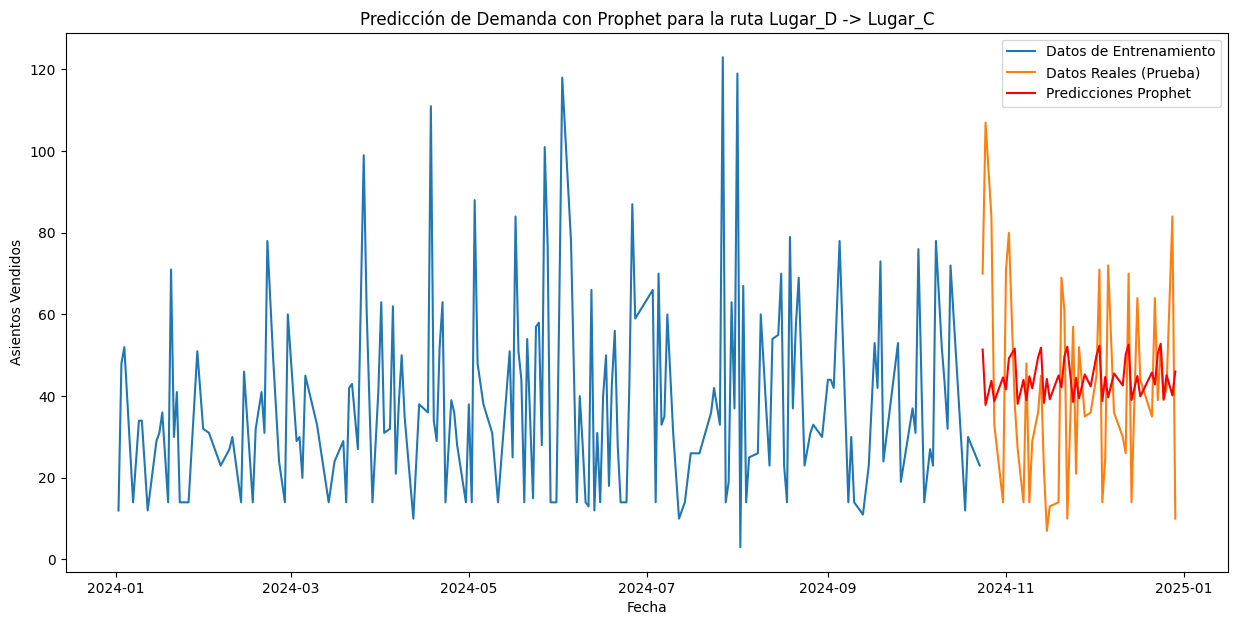

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/rbxtoy9_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/o6kq_ilg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69887', 'data', 'file=/tmp/tmpuukp5bmj/rbxtoy9_.json', 'init=/tmp/tmpuukp5bmj/o6kq_ilg.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_model94_ubn6z/prophet_model-20250703023609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_E -> Lugar_E ---
Ruta Lugar_E -> Lugar_E - RMSE con Prophet: 23.719513571432113


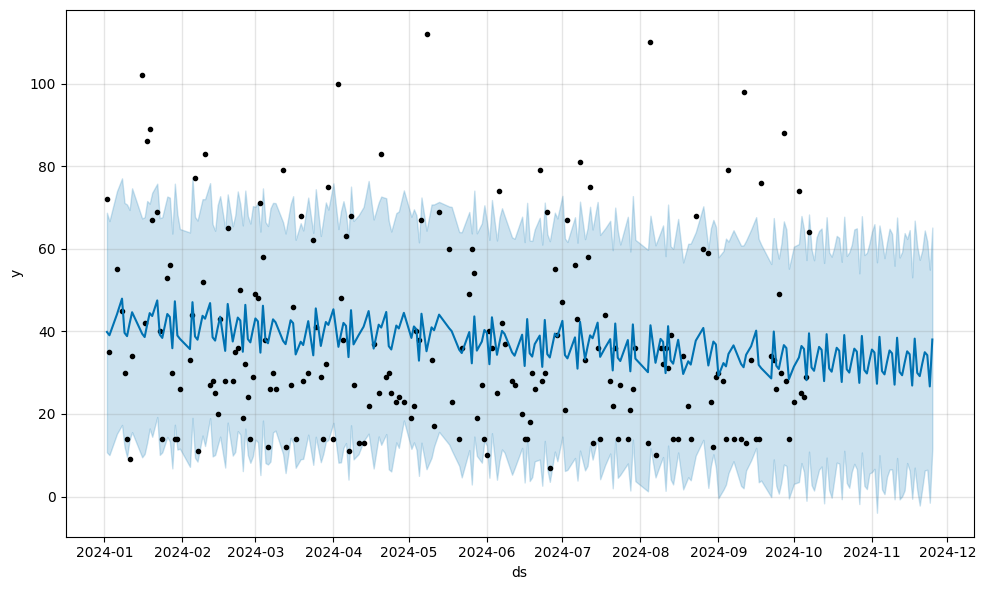

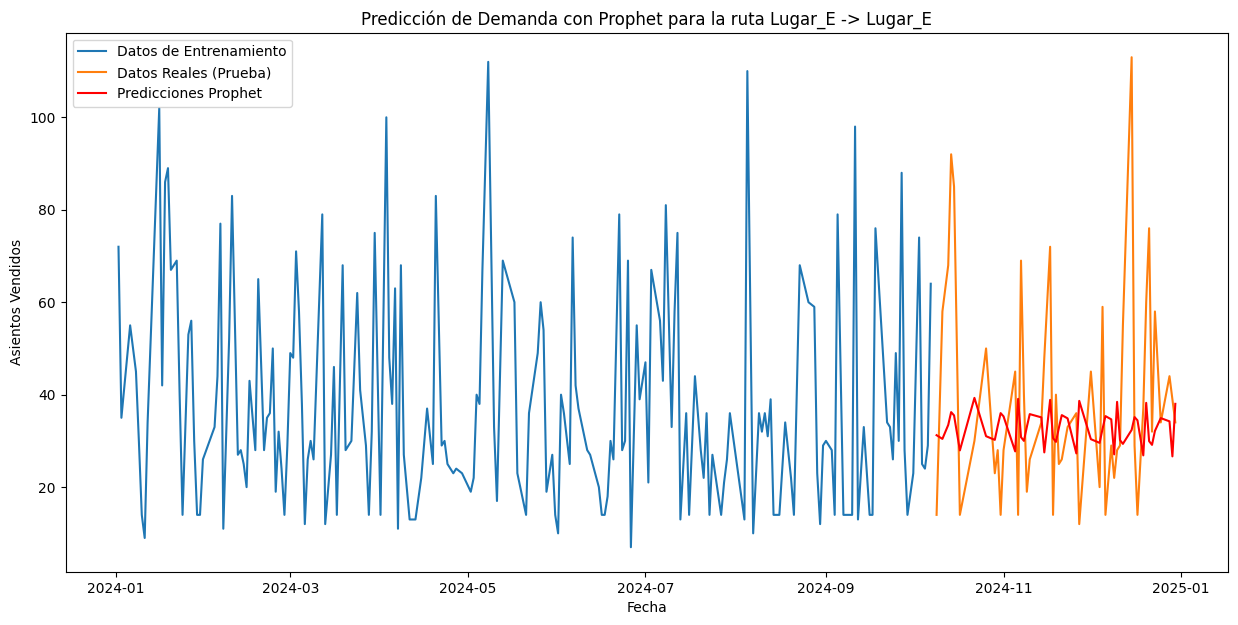

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/mcnbxxcd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/m38mmj6r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87387', 'data', 'file=/tmp/tmpuukp5bmj/mcnbxxcd.json', 'init=/tmp/tmpuukp5bmj/m38mmj6r.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelfqw5gbrd/prophet_model-20250703023610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_C -> Lugar_B ---
Ruta Lugar_C -> Lugar_B - RMSE con Prophet: 24.241659739735862


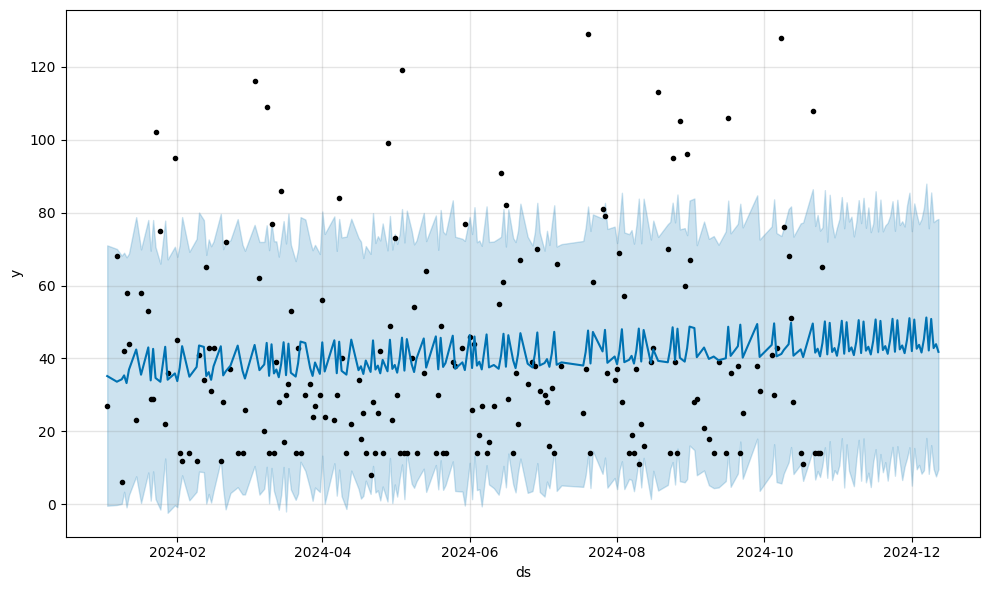

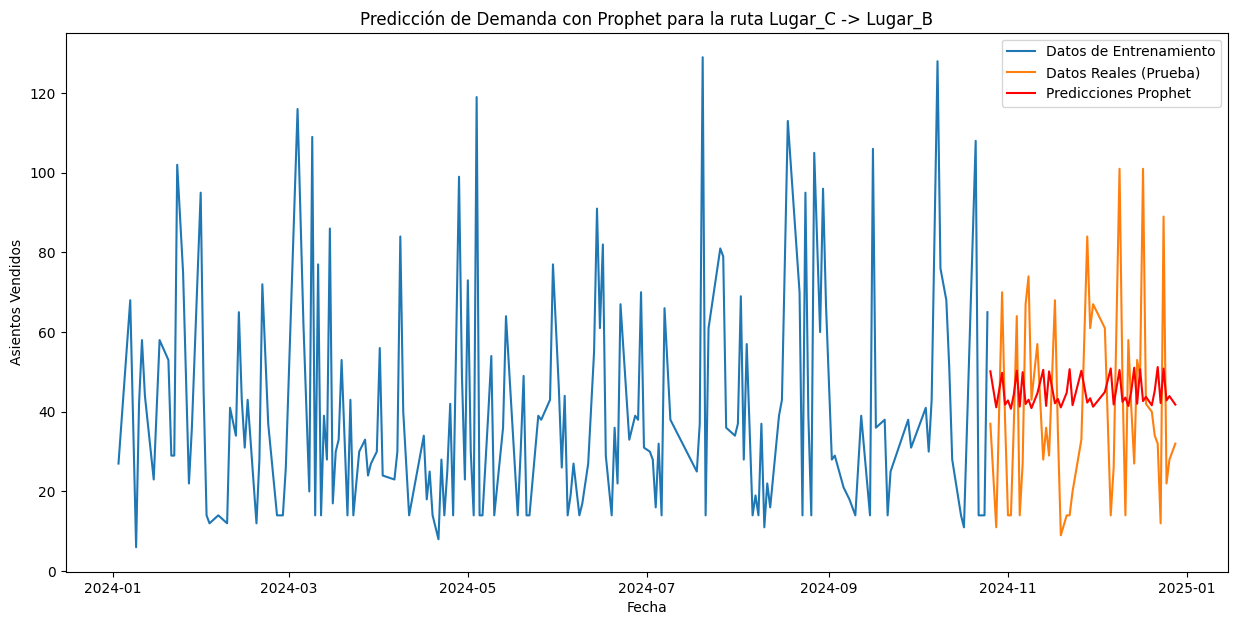

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/l_c94qoj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuukp5bmj/xksfg6kb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75673', 'data', 'file=/tmp/tmpuukp5bmj/l_c94qoj.json', 'init=/tmp/tmpuukp5bmj/xksfg6kb.json', 'output', 'file=/tmp/tmpuukp5bmj/prophet_modelhqmn6mpm/prophet_model-20250703023611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:36:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:36:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


--- Procesando Ruta: Lugar_E -> Lugar_C ---
Ruta Lugar_E -> Lugar_C - RMSE con Prophet: 23.725405562448284


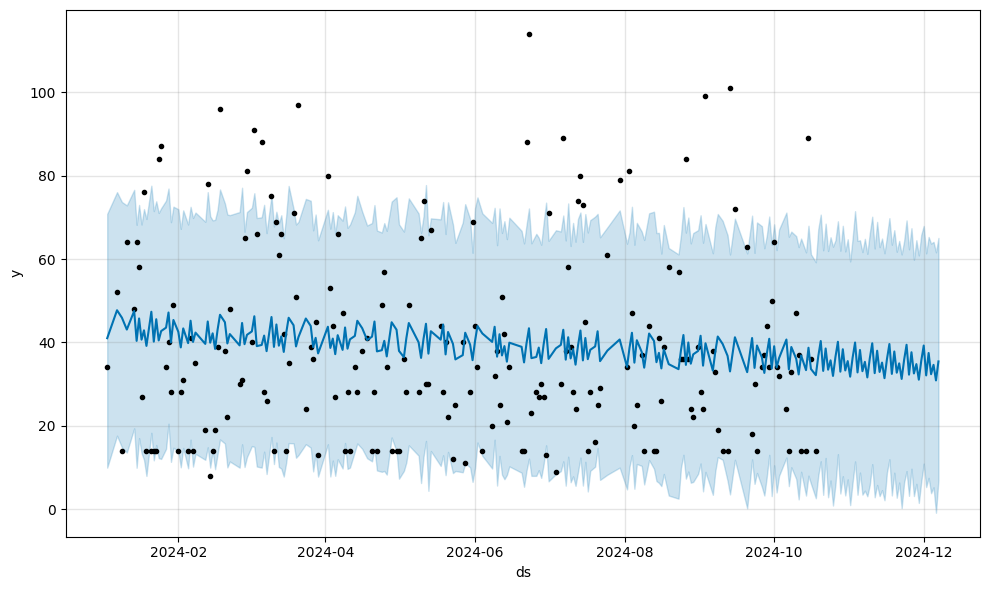

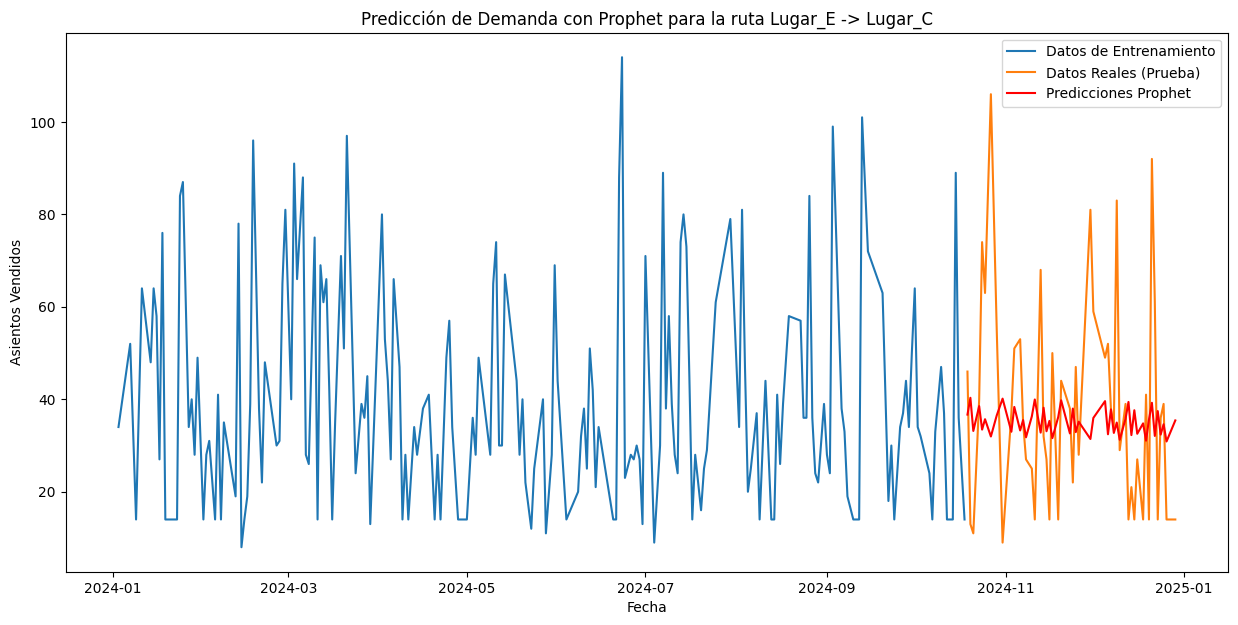


--- RESUMEN FINAL DE MÉTRICAS (Prophet) ---
                         rmse
ruta                         
Lugar_A -> Lugar_A  26.317227
Lugar_A -> Lugar_C  35.711982
Lugar_A -> Lugar_D  33.033393
Lugar_A -> Lugar_E  23.258037
Lugar_B -> Lugar_A  22.381299
Lugar_B -> Lugar_B  23.508567
Lugar_B -> Lugar_C  23.531494
Lugar_B -> Lugar_D  21.205663
Lugar_B -> Lugar_E  22.533584
Lugar_C -> Lugar_A  25.796458
Lugar_C -> Lugar_C  27.336831
Lugar_D -> Lugar_A  21.585785
Lugar_D -> Lugar_D  22.946678
Lugar_D -> Lugar_E  23.173434
Lugar_E -> Lugar_A  29.344702
Lugar_E -> Lugar_B  22.400251
Lugar_E -> Lugar_D  28.889137
Lugar_A -> Lugar_B  27.360901
Lugar_C -> Lugar_D  25.808900
Lugar_C -> Lugar_E  23.805824
Lugar_D -> Lugar_B  27.324147
Lugar_D -> Lugar_C  24.307369
Lugar_E -> Lugar_E  23.719514
Lugar_C -> Lugar_B  24.241660
Lugar_E -> Lugar_C  23.725406


In [23]:

from prophet import Prophet


# Obtener la demanda total por ruta y fecha
demanda_por_ruta = data.groupby(['fecha_viaje', 'origen', 'destino'])['asientos_vendidos'].sum().reset_index()

# Obtener una lista de rutas únicas
rutas_unicas = demanda_por_ruta[['origen', 'destino']].drop_duplicates()

# Lista para almacenar los resultados
resultados_prophet = []

print(f"\nSe encontraron {len(rutas_unicas)} rutas únicas. Iniciando procesamiento con Prophet...")


for index, fila in rutas_unicas.iterrows():
    ruta = f"{fila['origen']} -> {fila['destino']}"
    print(f"--- Procesando Ruta: {ruta} ---")

    # Filtrar los datos para la ruta específica
    df_ruta = demanda_por_ruta[(demanda_por_ruta['origen'] == fila['origen']) & (demanda_por_ruta['destino'] == fila['destino'])].copy()

    if df_ruta.empty:
        print(f"No hay datos para la ruta {ruta}. Saltando.")
        continue

    # 1. PREPARAR DATOS PARA PROPHET
    # Prophet necesita un DataFrame con columnas 'ds' (fecha) y 'y' (valor)
    df_prophet = df_ruta[['fecha_viaje', 'asientos_vendidos']].copy()
    df_prophet.rename(columns={'fecha_viaje': 'ds', 'asientos_vendidos': 'y'}, inplace=True)

    # Asegurarse de que la columna 'ds' sea datetime
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])


    # Dividir en entrenamiento y prueba
    train_size = int(len(df_prophet) * 0.8)
    df_prophet_train = df_prophet.iloc[:train_size]
    df_prophet_test = df_prophet.iloc[train_size:]

    # 2. CREAR Y ENTRENAR EL MODELO PROPHET
    # Prophet detectará la estacionalidad anual y semanal por defecto.
    # 'weekly_seasonality=True' es clave para tus datos.
    modelo_prophet = Prophet(weekly_seasonality=True, daily_seasonality=False)



    modelo_prophet.fit(df_prophet_train)

    # 3. REALIZAR PREDICCIONES
    # Crea un dataframe futuro para el período de prueba
    future = modelo_prophet.make_future_dataframe(periods=len(df_prophet_test), freq='D')

    # Realiza la predicción
    forecast = modelo_prophet.predict(future)

    # 4. EXTRAER LAS PREDICCIONES
    # Las predicciones están en la columna 'yhat' del dataframe 'forecast'
    # Nos quedamos solo con las que corresponden al período de prueba
    predicciones = forecast['yhat'].iloc[-len(df_prophet_test):]


    y_real = df_prophet_test['y']

    mse = mean_squared_error(y_real, predicciones)
    rmse = np.sqrt(mse)

    print(f"Ruta {ruta} - RMSE con Prophet: {rmse}")

    # Para graficar, usamos el propio plot de Prophet que es muy informativo
    fig = modelo_prophet.plot(forecast)
    plt.figure(figsize=(15, 7))
    plt.plot(df_prophet_train['ds'], df_prophet_train['y'], label='Datos de Entrenamiento')
    plt.plot(df_prophet_test['ds'], df_prophet_test['y'], label='Datos Reales (Prueba)')
    plt.plot(df_prophet_test['ds'], predicciones, label='Predicciones Prophet', color='red')
    plt.title(f'Predicción de Demanda con Prophet para la ruta {ruta}')
    plt.xlabel('Fecha')
    plt.ylabel('Asientos Vendidos')
    plt.legend()
    plt.show()

    resultados_prophet.append({'ruta': ruta, 'rmse': rmse})


# Mostrar un resumen final de los resultados
print("\n--- RESUMEN FINAL DE MÉTRICAS (Prophet) ---")
if resultados_prophet:
    resultados_prophet_df = pd.DataFrame(resultados_prophet).set_index('ruta')
    print(resultados_prophet_df[['rmse']])
else:
    print("No se procesaron rutas con éxito.")

## Bibliografía